## Download the dataset and check it's there

In [17]:
!ls ModelNet40/ModelNet40/airplane

test  train


# Dataset Loader

Load the ModelNet40 dataset

In [1]:
import os
import trimesh
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

# Dataset Loader class
class ModelNet40Dataset(Dataset):
    def __init__(self, root_dir, split='train', augment=False, voxel_size=32):
        self.root_dir = root_dir
        self.split = split
        self.augment = augment
        self.voxel_size = voxel_size
        
        # Filter out non-directory files like '.DS_Store'
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        assert len(self.classes) == 40, f"Expected 40 classes, but found {len(self.classes)} classes."
        
        self.files = []

        # Collect all .off files
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name, self.split)
            if not os.path.isdir(class_dir):
                continue
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.off'):
                    self.files.append((class_name, os.path.join(class_dir, file_name)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        class_name, file_path = self.files[idx]
        mesh = trimesh.load(file_path)

        if not isinstance(mesh, trimesh.Trimesh):
            print(f"Warning: {file_path} did not load properly.")
            return None, None

        vertices = torch.tensor(mesh.vertices, dtype=torch.float32)

        vertices = self.normalize(vertices)

        if self.augment:
            vertices = self.augment_data(vertices)

        voxel_grid = self.point_cloud_to_voxel(vertices)

        label = self.classes.index(class_name)
        
        # Ensure label is within the correct range
        assert label < 40, f"Label {label} out of range for class {class_name}"

        return voxel_grid, label

    def normalize(self, vertices):
        centroid = vertices.mean(dim=0)
        vertices = vertices - centroid
        scale = vertices.norm(p=2, dim=1).max()
        vertices = vertices / scale
        return vertices

    def augment_data(self, vertices):
        angle = torch.tensor(random.uniform(0, 2 * torch.pi))
        rotation_matrix = torch.tensor([
            [torch.cos(angle), -torch.sin(angle), 0],
            [torch.sin(angle), torch.cos(angle), 0],
            [0, 0, 1]
        ])
        vertices = vertices @ rotation_matrix.T

        scale_factor = random.uniform(0.95, 1.05)
        vertices *= scale_factor

        translation = torch.tensor([random.uniform(-0.05, 0.05) for _ in range(3)])
        vertices += translation

        return vertices

    def point_cloud_to_voxel(self, vertices):
        voxel_grid = np.zeros((self.voxel_size, self.voxel_size, self.voxel_size), dtype=np.float32)
        
        vertices = vertices.numpy()  # Convert to NumPy array for processing
        vertices = ((vertices + 1) / 2) * (self.voxel_size - 1)
        vertices = np.clip(vertices, 0, self.voxel_size - 1)  # Clamp indices to valid range
        vertices = vertices.astype(np.int32)
        
        voxel_grid[vertices[:, 0], vertices[:, 1], vertices[:, 2]] = 1.0
        
        voxel_grid = torch.tensor(voxel_grid).unsqueeze(0)
        
        return voxel_grid
    
def collate(batch):
    voxel_grids, labels = zip(*batch)
    voxel_grids = torch.stack(voxel_grids, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return voxel_grids, labels

# Model Architecture
## 3D CNN model used the VoxelNet architecture

In [2]:
# Voxel-based 3D CNN model with Adaptive Pooling
class VoxelNet(nn.Module):
    def __init__(self, num_classes=40):
        super(VoxelNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.conv4 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm3d(256)
        
        # Adaptive Max Pooling to ensure fixed output size regardless of input size
        self.pool = nn.AdaptiveMaxPool3d((4, 4, 4))
        
        # Now we know the flattened size will be 256 * 4 * 4 * 4
        self.fc1 = nn.Linear(256 * 4 * 4 * 4, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        # Flatten the output before feeding into fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.fc3(x)
        return x

# Model Training and Evaluation (no patches)

Define training and evaluating methods to train the model without a patch

In [3]:
def train_model(model, dataloader, optimizer, criterion, device, max_batches=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break

        voxels = voxels.to(device)
        labels = labels.to(device)
        
        # Debugging: Print labels to ensure they are within range
        if labels.max() >= 40:
            print(f"Error: Label out of bounds detected - {labels}")

        optimizer.zero_grad()
        outputs = model(voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_model(model, dataloader, criterion, device, max_batches=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (voxels, labels) in enumerate(dataloader):
            if max_batches and batch_idx >= max_batches:
                break

            voxels = voxels.to(device)
            labels = labels.to(device)

            outputs = model(voxels)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [4]:
# Main script remains the same
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on the {device} environment")

model = VoxelNet(num_classes=40).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

train_dataset = ModelNet40Dataset(root_dir='ModelNet40/ModelNet40', augment=True, voxel_size=32)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate, num_workers=0)

val_dataset = ModelNet40Dataset(root_dir='ModelNet40/ModelNet40', split='test', voxel_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate)

The model is running on the cpu environment


/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Main Training Loop (no patches)

In [5]:
import time

best_val_acc = 0
early_stop_counter = 0
early_stop_patience = 10
no_patch_test_loss, no_patch_test_acc = 1, 0
no_patch_cumulative_losses = []
epoch_times = []  # Array to store execution time per epoch

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    
    # Start timing the epoch
    start_time = time.time()
    
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device, max_batches=40)
    val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device, max_batches=20)
    
    # Stop timing the epoch and calculate the duration
    epoch_duration = time.time() - start_time
    epoch_times.append(epoch_duration)
    
    no_patch_cumulative_losses.append(val_loss)
    no_patch_test_loss = min(no_patch_test_loss, val_loss)
    no_patch_test_acc = max(no_patch_test_acc, val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%, Time: {epoch_duration:.2f} seconds")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print(f'Test Loss: {no_patch_test_loss:.4f}, Test Accuracy: {no_patch_test_acc:.2f}%')

# Print out the epoch times
print("Execution time per epoch:", epoch_times)

Epoch 1 is running...
Epoch [1/10], Train Loss: 0.2174, Train Accuracy: 17.66%, Val Loss: 0.4645, Val Accuracy: 15.62%, Time: 60.32 seconds
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1906, Train Accuracy: 30.31%, Val Loss: 0.3115, Val Accuracy: 50.00%, Time: 61.42 seconds
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1774, Train Accuracy: 33.75%, Val Loss: 0.2699, Val Accuracy: 52.50%, Time: 68.70 seconds
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1739, Train Accuracy: 33.75%, Val Loss: 0.2762, Val Accuracy: 54.69%, Time: 65.78 seconds
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.1641, Train Accuracy: 35.94%, Val Loss: 0.2430, Val Accuracy: 57.50%, Time: 59.64 seconds
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.1604, Train Accuracy: 38.28%, Val Loss: 0.2230, Val Accuracy: 62.50%, Time: 58.27 seconds
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.1562, Train Accuracy: 37.50%, Val Loss: 0.2463, Val Accuracy: 55.94%, Time: 60.78 seconds
Epoch 8 is running..

In [5]:
# This is because I forgot to define these attributes when I was running the model
# It takes way too long to run so I manually added the loss values 
no_patch_cumulative_losses = [0.4714, 0.3007, 0.2589, 0.2391, 0.2521, 0.2107, 0.2247]
no_patch_test_loss = 0.2107
no_patch_test_acc = 64.69

In [6]:
regular_epoch_times = [441.0253077533662, 449.0912443143398, 502.2973444255007, 480.9473706525208, 436.0593119637037, 426.05139850105587, 444.412783133399, 489.82370428539434, 530.711142380787, 510.964174661567]
best_model_epoch_times = [60.31769514083862, 61.42084884643555, 68.69768595695496, 65.77771472930908, 59.638510942459106, 58.26975893974304, 60.7809898853302, 66.99170398712158, 72.5837550163269, 69.88302206993103]

In [7]:
regular_performance_no_patch_test_acc = 55.87

## Select the best models from the dataset

In [23]:
def evaluate_model_per_class(model, dataloader, criterion, device, num_classes=40):
    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        print(f"Running {len(dataloader)} rounds...")
        for voxels, labels in dataloader:
            voxels = voxels.to(device)
            labels = labels.to(device)

            outputs = model(voxels)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).squeeze()

            for j in range(len(labels)):
                label = labels[j].item()
                class_correct[label] += correct[j].item()
                class_total[label] += 1

    class_accuracy = [100 * c / t if t > 0 else 0 for c, t in zip(class_correct, class_total)]
    return class_accuracy

class_accuracy = evaluate_model_per_class(model, val_dataloader, criterion, device)
for i, acc in enumerate(class_accuracy):
    print(f'Class {i}: Accuracy {acc:.2f}%')

Running 155 rounds...
Class 0: Accuracy 94.00%
Class 1: Accuracy 0.00%
Class 2: Accuracy 69.00%
Class 3: Accuracy 0.00%
Class 4: Accuracy 82.00%
Class 5: Accuracy 74.00%
Class 6: Accuracy 10.00%
Class 7: Accuracy 80.00%
Class 8: Accuracy 90.00%
Class 9: Accuracy 40.00%
Class 10: Accuracy 0.00%
Class 11: Accuracy 20.00%
Class 12: Accuracy 0.00%
Class 13: Accuracy 0.00%
Class 14: Accuracy 0.00%
Class 15: Accuracy 0.00%
Class 16: Accuracy 14.00%
Class 17: Accuracy 22.00%
Class 18: Accuracy 25.00%
Class 19: Accuracy 0.00%
Class 20: Accuracy 0.00%
Class 21: Accuracy 6.00%
Class 22: Accuracy 85.00%
Class 23: Accuracy 0.00%
Class 24: Accuracy 0.00%
Class 25: Accuracy 0.00%
Class 26: Accuracy 38.00%
Class 27: Accuracy 0.00%
Class 28: Accuracy 0.00%
Class 29: Accuracy 0.00%
Class 30: Accuracy 67.00%
Class 31: Accuracy 0.00%
Class 32: Accuracy 0.00%
Class 33: Accuracy 65.00%
Class 34: Accuracy 20.00%
Class 35: Accuracy 28.00%
Class 36: Accuracy 0.00%
Class 37: Accuracy 58.00%
Class 38: Accuracy 

In [24]:
# Initialize a dictionary to store the best model for each class
best_class_models = {}

# Initialize the dictionary entries
for class_id in range(40):
    best_class_models[class_id] = {
        "model": None,  # Placeholder for the best model's state_dict
        "accuracy": 0   # Placeholder for the best accuracy achieved for this class
    }

In [41]:
def save_best_model_per_class(model, dataloader, criterion, device):
    global best_class_models
    
    # Evaluate the model per class
    class_accuracy = evaluate_model_per_class(model, dataloader, criterion, device)
    
    for class_id in range(40):
        if class_accuracy[class_id] > best_class_models[class_id]["accuracy"]:
            # Update the best accuracy
            best_class_models[class_id]["accuracy"] = class_accuracy[class_id]
            # Save the best model's state_dict directly
            best_class_models[class_id]["model"] = model.state_dict()  # No need to copy explicitly

In [25]:
# Modify the training loop to save the best model for each class
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device, max_batches=40)
    val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device, max_batches=20)
    
    # Save the best model for each class
    save_best_model_per_class(model, val_dataloader, criterion, device)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

Running 155 rounds...
Epoch [1/7], Train Loss: 0.1480, Train Accuracy: 40.31%, Val Loss: 0.2184, Val Accuracy: 60.62%
Running 155 rounds...
Epoch [2/7], Train Loss: 0.1442, Train Accuracy: 45.47%, Val Loss: 0.1965, Val Accuracy: 65.31%
Running 155 rounds...
Epoch [3/7], Train Loss: 0.1472, Train Accuracy: 40.78%, Val Loss: 0.2180, Val Accuracy: 63.75%
Running 155 rounds...
Epoch [4/7], Train Loss: 0.1355, Train Accuracy: 47.50%, Val Loss: 0.2098, Val Accuracy: 58.75%
Running 155 rounds...
Epoch [5/7], Train Loss: 0.1354, Train Accuracy: 44.53%, Val Loss: 0.1808, Val Accuracy: 67.50%
Running 155 rounds...
Epoch [6/7], Train Loss: 0.1265, Train Accuracy: 49.38%, Val Loss: 0.1815, Val Accuracy: 62.50%
Running 155 rounds...
Epoch [7/7], Train Loss: 0.1309, Train Accuracy: 46.72%, Val Loss: 0.1950, Val Accuracy: 59.38%


# Adverserial Attacks

## Gaussian Attack Patch
Define the main gaussian attack adverserial attack method

In [8]:
def gaussian_attack(voxel_grids, mean=0.0, stddev=0.01):
    # Generate Gaussian noise
    noise = torch.normal(mean, stddev, size=voxel_grids.size(), device=voxel_grids.device)

    # Apply the noise to the voxel grids
    perturbed_voxel_grids = voxel_grids + noise

    # Ensure the voxel values remain in a valid range (e.g., [0, 1] if binary)
    perturbed_voxel_grids = torch.clamp(perturbed_voxel_grids, 0, 1)

    return perturbed_voxel_grids

Training and Evaluation methods for GA Patch

In [9]:
def train_model_with_gaussian_attack(model, dataloader, optimizer, criterion, device, mean=0.0, stddev=0.01, max_batches=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply Gaussian attack to the voxel grids
        perturbed_voxels = gaussian_attack(voxels, mean, stddev)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_with_gaussian_attack(model, dataloader, criterion, device, mean=0.0, stddev=0.01, max_batches=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (voxels, labels) in enumerate(dataloader):
            if max_batches and batch_idx >= max_batches:
                break
            voxels = voxels.to(device)
            labels = labels.to(device).long()

            perturbed_voxels = gaussian_attack(voxels, mean, stddev)

            outputs = model(perturbed_voxels)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

## Main training loop for GA patch

In [10]:
# Main training loop with Gaussian attack
gaussian_mean = 0.0
gaussian_stddev = 0.02  # Adjust the standard deviation to control the strength of the attack
ga_test_loss, ga_test_acc = 1, 0
ga_cumulative_loss = []

In [71]:
# Evaluate the model with the patch without training
ga_no_training_val_loss, ga_no_training_val_acc = evaluate_with_gaussian_attack(model, val_dataloader, criterion, device, mean=gaussian_mean, stddev=gaussian_stddev, max_batches=20)

print(f'Gaussian Attack (no training) - Test Loss: {ga_no_training_val_loss:.4f}, Test Accuracy: {ga_no_training_val_acc:.2f}%')

Gaussian Attack (no training) - Test Loss: 0.2552, Test Accuracy: 45.00%


In [11]:
ga_no_training_val_loss = 0.2552
ga_no_training_val_acc = 45.00

In [72]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    train_loss, train_acc = train_model_with_gaussian_attack(model, train_dataloader, optimizer, criterion, device, mean=gaussian_mean, stddev=gaussian_stddev, max_batches=40)
    val_loss, val_acc = evaluate_with_gaussian_attack(model, val_dataloader, criterion, device, mean=gaussian_mean, stddev=gaussian_stddev, max_batches=20)

    ga_cumulative_loss.append(val_loss)
    ga_test_loss = min(ga_test_loss, val_loss)
    ga_test_acc = max(ga_test_acc, val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

print(f'Gaussian Attack - Test Loss: {ga_test_loss:.4f}, Test Accuracy: {ga_test_acc:.2f}%')


Epoch 1 is running...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1043629f0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


In [12]:
# This is because I forgot to define these attributes when I was running the model
# It takes way too long to run so I manually added the loss values 
ga_cumulative_loss = [0.2190, 0.2058, 0.2157, 0.2093, 0.1952, 0.1953, 0.1862, 0.1897, 0.1758, 0.1889]
ga_test_loss = 0.1758
ga_test_acc = 67.62

## Evaluate Guassian with different standard deviations

In [11]:
# Train the model first with the patch
num_epochs = 7
gaussian_mean = 0.0
gaussian_stddev = 0.02  # Adjust the standard deviation to control the strength of the attack
ga_test_loss, ga_test_acc = 1, 0
ga_cumulative_loss = []
for epoch in range(num_epochs):
    train_loss, train_acc = train_model_with_gaussian_attack(model, train_dataloader, optimizer, criterion, device, mean=gaussian_mean, stddev=gaussian_stddev, max_batches=40)

ga_eval_vars = []
for stddev in [0.2, 0.02, 0.002]:
    val_loss, val_acc = evaluate_with_gaussian_attack(model, val_dataloader, criterion, device, mean=gaussian_mean, stddev=stddev, max_batches=20)
    print(f'Guassian Attack with standard deviation {stddev} - Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.2f}%')
    ga_eval_vars.append([val_loss, val_acc])

/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Guassian Attack with standard deviation 0.2 - Test Loss: 0.4578, Test Accuracy: 13.75%
Guassian Attack with standard deviation 0.02 - Test Loss: 0.2271, Test Accuracy: 60.00%
Guassian Attack with standard deviation 0.002 - Test Loss: 0.2190, Test Accuracy: 59.69%


In [13]:
ga_eval_vars = [[0.4578, 13.75], [0.2271, 60.00], [0.2190, 59.69]]

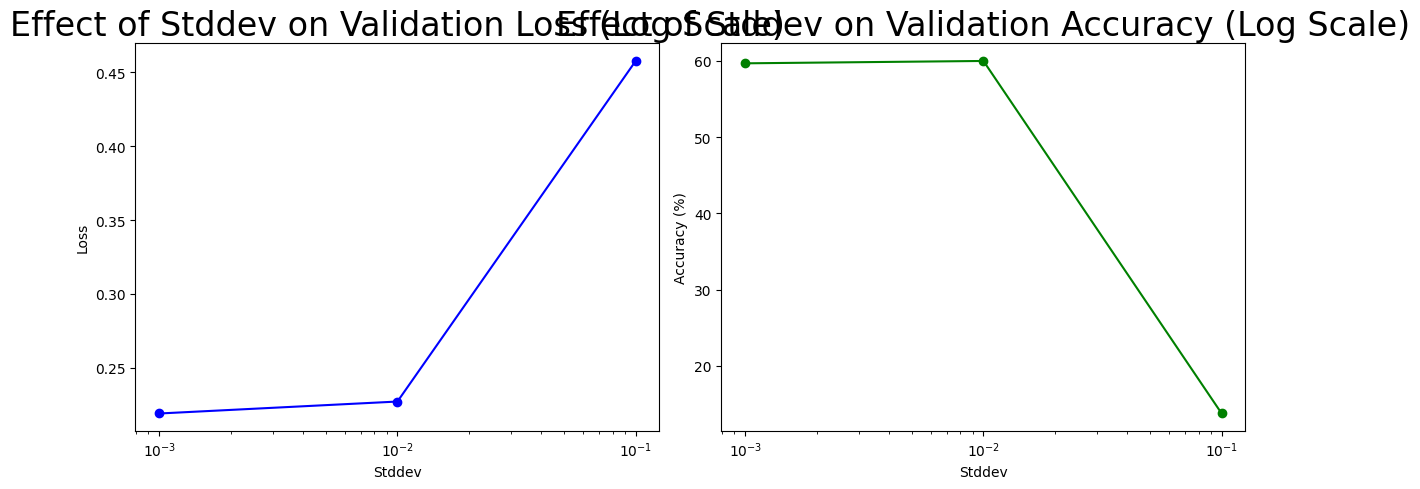

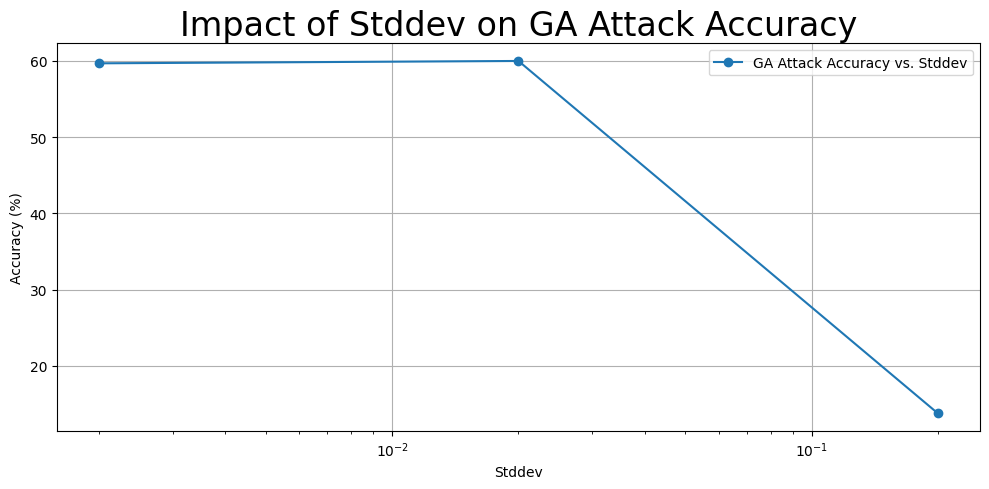

In [17]:
import matplotlib.pyplot as plt

# 1. Plotting Effect of Different Stddev Values

epsilons = [0.1, 0.01, 0.001]
ga_eval_loss = [vars[0] for vars in ga_eval_vars]
ga_eval_acc = [vars[1] for vars in ga_eval_vars]

plt.figure(figsize=(12, 5))

# Loss vs Stddev
plt.subplot(1, 2, 1)
plt.plot(epsilons, ga_eval_loss, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Stddev')
plt.ylabel('Loss')
plt.title('Effect of Stddev on Validation Loss (Log Scale)', fontsize=24)

# Accuracy vs Epsilon
plt.subplot(1, 2, 2)
plt.plot(epsilons, ga_eval_acc, marker='o', linestyle='-', color='green')
plt.xscale('log')
plt.xlabel('Stddev')
plt.ylabel('Accuracy (%)')
plt.title('Effect of Stddev on Validation Accuracy (Log Scale)', fontsize=24)

plt.tight_layout()
plt.show()

# 3. Accuracy vs. Stddev
epsilons = [0.2, 0.02, 0.002]
pgd_epsilon_acc = [val[1] for val in ga_eval_vars]  # Extract accuracy for each stddev

plt.figure(figsize=(10, 5))
plt.plot(epsilons, pgd_epsilon_acc, label="GA Attack Accuracy vs. Stddev", marker='o')
plt.title('Impact of Stddev on GA Attack Accuracy', fontsize=24)
plt.xlabel('Stddev')
plt.ylabel('Accuracy (%)')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## FGSM Attack Patch
Define main FGSM adverserial attack method

In [18]:
def fgsm_attack(voxel_grids, labels, model, criterion, epsilon=0.01):
    model.eval()
    voxel_grids.requires_grad = True

    # Forward pass through the model
    outputs = model(voxel_grids)
    loss = criterion(outputs, labels)

    # Backward pass to calculate gradients
    model.zero_grad()
    loss.backward()

    # FGSM perturbation: sign of the gradient
    perturbation = epsilon * voxel_grids.grad.sign()

    # Apply the perturbation to the voxel grids
    perturbed_voxel_grids = voxel_grids + perturbation

    # Ensure voxel grid values remain in a valid range (e.g., [0, 1])
    perturbed_voxel_grids = torch.clamp(perturbed_voxel_grids, 0, 1)

    return perturbed_voxel_grids

In [19]:
def train_model_with_fgsm_attack(model, dataloader, optimizer, criterion, device, epsilon=0.01, max_batches=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply FGSM attack to the voxel grids
        perturbed_voxels = fgsm_attack(voxels, labels, model, criterion, epsilon)

        # Forward pass with perturbed voxel grids
        optimizer.zero_grad()
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_with_fgsm_attack(model, dataloader, criterion, device, epsilon=0.01, max_batches=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        perturbed_voxels = fgsm_attack(voxels, labels, model, criterion, epsilon)

        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

## Main training loop for FGSM patch

In [20]:
# Main training loop with FGSM attack
fgsm_epsilon = 0.01  # Adjust the epsilon value to control the strength of the attack
fgsm_test_loss, fgsm_test_acc = 1, 0
fgsm_cumulative_loss = []

In [15]:
# Evaluate the model with the patch without training
fgsm_no_training_val_loss, fgsm_no_training_val_acc = evaluate_with_fgsm_attack(model, val_dataloader, criterion, device, epsilon=fgsm_epsilon, max_batches=20)
print(f'FGSM Attack (no training) - Test Loss: {fgsm_no_training_val_loss:.4f}, Test Accuracy: {fgsm_no_training_val_acc:.2f}%')

FGSM Attack (no training) - Test Loss: 0.2302, Test Accuracy: 58.44%


In [21]:
fgsm_no_training_val_loss = 0.2302
fgsm_no_training_val_acc = 58.44

In [5]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    train_loss, train_acc = train_model_with_fgsm_attack(model, train_dataloader, optimizer, criterion, device, epsilon=fgsm_epsilon, max_batches=40)
    val_loss, val_acc = evaluate_with_fgsm_attack(model, val_dataloader, criterion, device, epsilon=fgsm_epsilon, max_batches=20)

    fgsm_cumulative_loss.append(val_loss)
    fgsm_test_loss = min(fgsm_test_loss, val_loss)
    fgsm_test_acc = max(fgsm_test_acc, val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

print(f'FGSM Attack - Test Loss: {fgsm_test_loss:.4f}, Test Accuracy: {fgsm_test_acc:.2f}%')


Epoch 1 is running...
Epoch [1/10], Train Loss: 0.1271, Train Accuracy: 45.47%, Val Loss: 0.2113, Val Accuracy: 55.94%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1173, Train Accuracy: 48.28%, Val Loss: 0.2135, Val Accuracy: 56.25%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1052, Train Accuracy: 52.66%, Val Loss: 0.1839, Val Accuracy: 60.31%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1051, Train Accuracy: 53.59%, Val Loss: 0.1835, Val Accuracy: 60.00%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.0994, Train Accuracy: 54.84%, Val Loss: 0.1845, Val Accuracy: 59.69%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.0973, Train Accuracy: 58.59%, Val Loss: 0.1906, Val Accuracy: 58.44%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.0931, Train Accuracy: 57.19%, Val Loss: 0.2078, Val Accuracy: 57.19%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.0928, Train Accuracy: 58.75%, Val Loss: 0.2049, Val Accuracy: 58.75%
Epoch 9 is running...
Epoch [9/10], Train Loss: 

In [22]:
# This is because I forgot to define these attributes when I was running the model
# It takes way too long to run so I manually added the loss values 
fgsm_cumulative_loss = [0.2113, 0.2135, 0.1839, 0.1835, 0.1845, 0.1906, 0.2078, 0.2049, 0.1905, 0.1841]
fgsm_test_loss = 0.1835
fgsm_test_acc = 62.94

## Evaluate FGSM with different levels of perturbations

In [17]:
# Train the model first with the patch
num_epochs = 7
for epoch in range(num_epochs):
    train_loss, train_acc = train_model_with_fgsm_attack(model, train_dataloader, optimizer, criterion, device, epsilon=fgsm_epsilon, max_batches=40)

fgsm_eval_vars = []
for epsilon in [0.1, 0.01, 0.001]:
    val_loss, val_acc = evaluate_with_fgsm_attack(model, val_dataloader, criterion, device, epsilon=epsilon, max_batches=20)
    print(f'FGSM Attack with epsilon {epsilon} - Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.2f}%')
    fgsm_eval_vars.append([val_loss, val_acc])

/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


FGSM Attack with epsilon 0.1 - Test Loss: 0.4600, Test Accuracy: 11.56%
FGSM Attack with epsilon 0.01 - Test Loss: 0.2743, Test Accuracy: 45.00%
FGSM Attack with epsilon 0.001 - Test Loss: 0.2602, Test Accuracy: 46.88%


In [23]:
fgsm_eval_vars = [[0.4600, 11.56], [0.2743, 45.00], [0.2602, 46.88]]

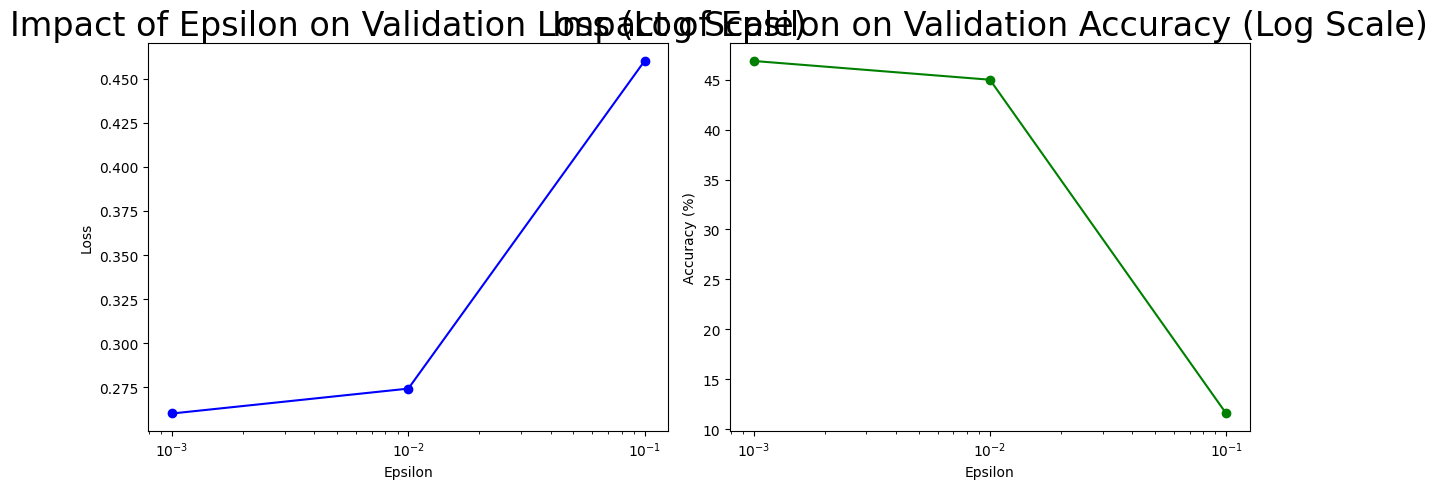

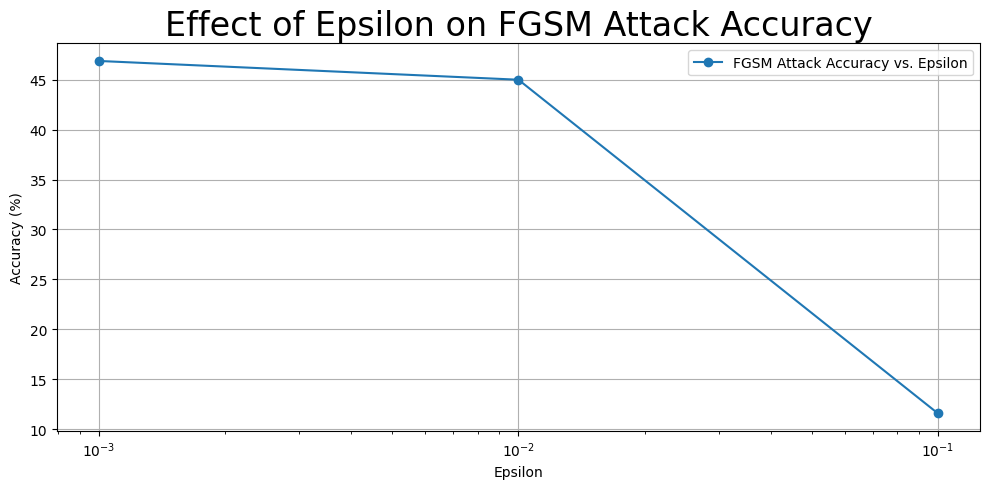

In [25]:
import matplotlib.pyplot as plt

# 1. Plotting Effect of Different Epsilon Values

epsilons = [0.1, 0.01, 0.001]
fgsm_eval_loss = [vars[0] for vars in fgsm_eval_vars]
fgsm_eval_acc = [vars[1] for vars in fgsm_eval_vars]

plt.figure(figsize=(12, 5))

# Loss vs Epsilon
plt.subplot(1, 2, 1)
plt.plot(epsilons, fgsm_eval_loss, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Loss')
plt.title('Impact of Epsilon on Validation Loss (Log Scale)', fontsize=24)

# Accuracy vs Epsilon
plt.subplot(1, 2, 2)
plt.plot(epsilons, fgsm_eval_acc, marker='o', linestyle='-', color='green')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Impact of Epsilon on Validation Accuracy (Log Scale)', fontsize=24)

plt.tight_layout()
plt.show()

# 3. Accuracy vs. Epsilon
epsilons = [0.1, 0.01, 0.001]  # Example epsilon values
fgsm_epsilon_acc = [val[1] for val in fgsm_eval_vars]  # Extract accuracy for each epsilon

plt.figure(figsize=(10, 5))
plt.plot(epsilons, fgsm_epsilon_acc, label="FGSM Attack Accuracy vs. Epsilon", marker='o')
plt.title('Effect of Epsilon on FGSM Attack Accuracy', fontsize=24)
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.xscale('log')  # Logarithmic scale for epsilon
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## PGD Attack Patch
Define the main PGD adverserial attack method

In [26]:
def pgd_attack(voxel_grids, labels, model, criterion, epsilon=0.01, alpha=0.001, num_iter=40):
    model.eval()

    original_voxel_grids = voxel_grids.clone().detach()
    perturbed_voxel_grids = original_voxel_grids.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        outputs = model(perturbed_voxel_grids)
        loss = criterion(outputs, labels)

        # Backward pass to calculate gradients
        model.zero_grad()
        loss.backward()

        # PGD step: apply FGSM-like perturbation
        perturbation = alpha * perturbed_voxel_grids.grad.sign()

        perturbed_voxel_grids = perturbed_voxel_grids.detach() + perturbation

        perturbation = torch.clamp(perturbed_voxel_grids - original_voxel_grids, -epsilon, epsilon)
        perturbed_voxel_grids = (original_voxel_grids + perturbation).clamp(0, 1).requires_grad_(True)

    return perturbed_voxel_grids

In [27]:
def train_model_with_pgd_attack(model, dataloader, optimizer, criterion, device, epsilon=0.01, alpha=0.001, num_iter=40, max_batches=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply PGD attack to the voxel grids
        perturbed_voxels = pgd_attack(voxels, labels, model, criterion, epsilon, alpha, num_iter)

        # Forward pass with perturbed voxel grids
        optimizer.zero_grad()
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_with_pgd_attack(model, dataloader, criterion, device, epsilon=0.01, alpha=0.001, num_iter=40, max_batches=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        perturbed_voxels = pgd_attack(voxels, labels, model, criterion, epsilon, alpha, num_iter)

        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

## Main training loop for PGD patch

In [28]:
# Main training loop with PGD attack
pgd_epsilon = 0.01
pgd_alpha = 0.001
pgd_num_iter = 10
pgd_test_loss, pgd_test_acc = 1, 0
pgd_cumulative_loss = []

In [48]:
# Evaluate the model with the patch with no training
pdg_no_training_val_loss, pdg_no_training_val_acc = evaluate_with_pgd_attack(model, val_dataloader, criterion, device, epsilon=pgd_epsilon, alpha=pgd_alpha, num_iter=pgd_num_iter, max_batches=20)
print(f'PGD Attack (no training) - Test Loss: {pdg_no_training_val_loss:.4f}, Test Accuracy: {pdg_no_training_val_acc:.2f}%')

PGD Attack (no training) - Test Loss: 0.2608, Test Accuracy: 42.81%


In [29]:
pdg_no_training_val_loss = 0.2608
pdg_no_training_val_acc = 42.81

In [7]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    train_loss, train_acc = train_model_with_pgd_attack(model, train_dataloader, optimizer, criterion, device, epsilon=pgd_epsilon, alpha=pgd_alpha, num_iter=pgd_num_iter, max_batches=40)
    val_loss, val_acc = evaluate_with_pgd_attack(model, val_dataloader, criterion, device, epsilon=pgd_epsilon, alpha=pgd_alpha, num_iter=pgd_num_iter, max_batches=20)

    pgd_cumulative_loss.append(val_loss)
    pgd_test_loss = min(pgd_test_loss, val_loss) 
    pgd_test_acc = max(pgd_test_acc, val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

print(f'PGD Attack - Test Loss: {pgd_test_loss:.4f}, Test Accuracy: {pgd_test_acc:.2f}%')

Epoch 1 is running...
Epoch [1/10], Train Loss: 0.0972, Train Accuracy: 56.41%, Val Loss: 0.1969, Val Accuracy: 59.06%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.0893, Train Accuracy: 58.44%, Val Loss: 0.1890, Val Accuracy: 58.44%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.0954, Train Accuracy: 56.88%, Val Loss: 0.1869, Val Accuracy: 59.38%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.0855, Train Accuracy: 60.94%, Val Loss: 0.1879, Val Accuracy: 59.38%
Epoch 5 is running...


/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Epoch [5/10], Train Loss: 0.0909, Train Accuracy: 59.06%, Val Loss: 0.1867, Val Accuracy: 58.75%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.0983, Train Accuracy: 56.88%, Val Loss: 0.1870, Val Accuracy: 59.69%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.0914, Train Accuracy: 58.91%, Val Loss: 0.1857, Val Accuracy: 59.38%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.0929, Train Accuracy: 58.12%, Val Loss: 0.1885, Val Accuracy: 58.75%
Epoch 9 is running...
Epoch [9/10], Train Loss: 0.0928, Train Accuracy: 58.12%, Val Loss: 0.1888, Val Accuracy: 59.06%
Epoch 10 is running...
Epoch [10/10], Train Loss: 0.0963, Train Accuracy: 58.75%, Val Loss: 0.1881, Val Accuracy: 58.75%
PGD Attack - Test Loss: 0.1969, Test Accuracy: 59.69%


In [30]:
# This is because I forgot to define these attributes when I was running the model
# It takes way too long to run so I manually added the loss values 
pgd_cumulative_loss = [0.1969, 0.1890, 0.1869, 0.1879, 0.1867, 0.1870, 0.1857, 0.1885, 0.1888, 0.1881]
pgd_test_loss = 0.1857
pgd_test_acc = 59.69

## Evaluate PGD with different levels of perturbations

In [53]:
# Train the model first with the patch
for epoch in range(num_epochs):
    train_loss, train_acc = train_model_with_pgd_attack(model, train_dataloader, optimizer, criterion, device, epsilon=pgd_epsilon, alpha=pgd_alpha, num_iter=pgd_num_iter, max_batches=40)

pdg_eval_vars = []
for epsilon in [0.1, 0.01, 0.001]:
    val_loss, val_acc = evaluate_with_pgd_attack(model, val_dataloader, criterion, device, epsilon=epsilon, alpha=pgd_alpha, num_iter=pgd_num_iter, max_batches=20)
    print(f'PGD Attack with epsilon {epsilon} - Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.2f}%')
    pdg_eval_vars.append([val_loss, val_acc])


PGD Attack with epsilon 0.1 - Test Loss: 0.2516, Test Accuracy: 49.06%
PGD Attack with epsilon 0.01 - Test Loss: 0.2516, Test Accuracy: 49.06%
PGD Attack with epsilon 0.001 - Test Loss: 0.2420, Test Accuracy: 50.94%



In [31]:
pdg_eval_vars = [[0.2516, 49.06], [0.2516, 49.06], [0.2420, 50.94]]

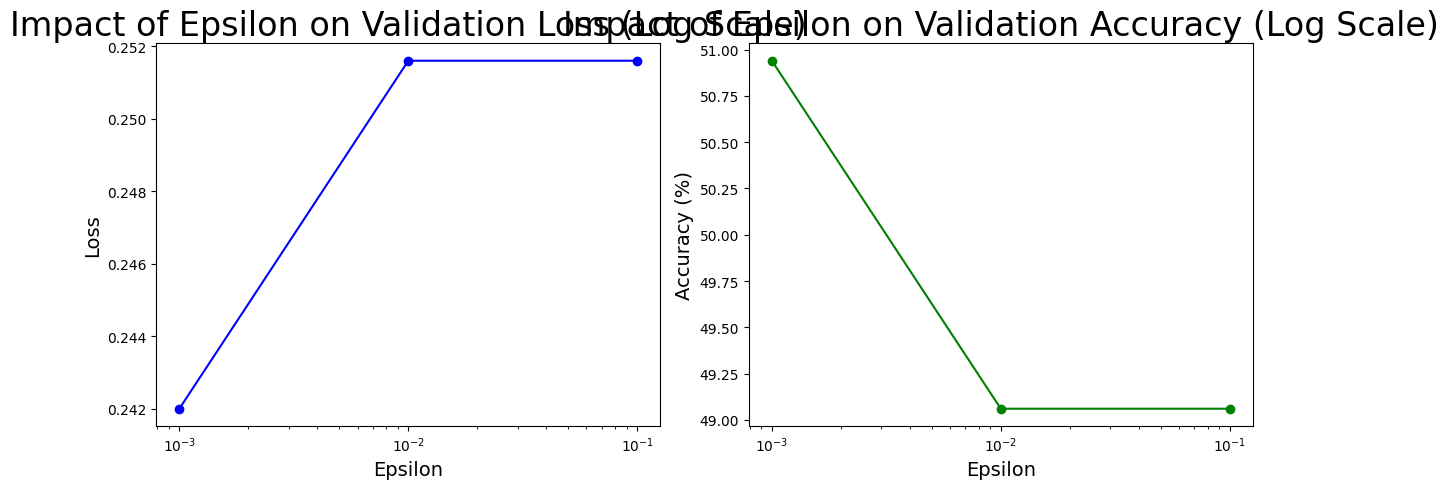

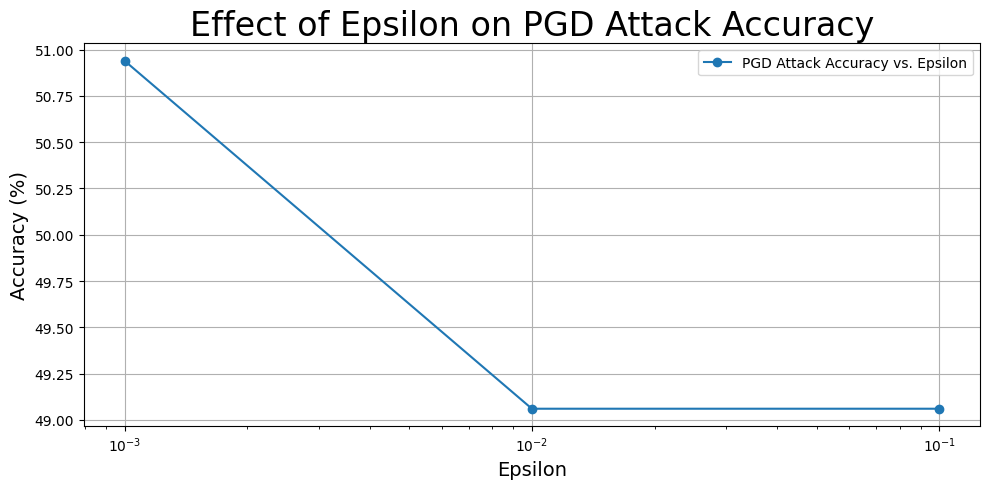

In [32]:
import matplotlib.pyplot as plt

# 1. Plotting Effect of Different Epsilon Values

epsilons = [0.1, 0.01, 0.001]
pgd_eval_loss = [vars[0] for vars in pdg_eval_vars]
pgd_eval_acc = [vars[1] for vars in pdg_eval_vars]

plt.figure(figsize=(12, 5))

# Loss vs Epsilon
plt.subplot(1, 2, 1)
plt.plot(epsilons, pgd_eval_loss, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Impact of Epsilon on Validation Loss (Log Scale)', fontsize=24)

# Accuracy vs Epsilon
plt.subplot(1, 2, 2)
plt.plot(epsilons, pgd_eval_acc, marker='o', linestyle='-', color='green')
plt.xscale('log')
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Impact of Epsilon on Validation Accuracy (Log Scale)', fontsize=24)

plt.tight_layout()
plt.show()

# 3. Accuracy vs. Epsilon
epsilons = [0.1, 0.01, 0.001]  # Example epsilon values
pgd_epsilon_acc = [val[1] for val in pdg_eval_vars]  # Extract accuracy for each epsilon

plt.figure(figsize=(10, 5))
plt.plot(epsilons, pgd_epsilon_acc, label="PGD Attack Accuracy vs. Epsilon", marker='o')
plt.title('Effect of Epsilon on PGD Attack Accuracy', fontsize=24)
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xscale('log')  # Logarithmic scale for epsilon
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## MIM Attack Patch
Define the main MIM adverserial attack method

In [33]:
def mim_attack(voxel_grids, labels, model, criterion, epsilon=0.01, alpha=0.001, num_iter=40, decay_factor=1.0):
    model.eval()

    perturbed_voxel_grids = voxel_grids.clone().detach().to(device)
    g = torch.zeros_like(perturbed_voxel_grids).to(device)  # Initialize momentum term

    for _ in range(num_iter):
        perturbed_voxel_grids.requires_grad = True  # Ensure gradients are tracked
        outputs = model(perturbed_voxel_grids)
        loss = criterion(outputs, labels)

        model.zero_grad()
        loss.backward()

        # Accumulate momentum
        grad = perturbed_voxel_grids.grad.data
        g = decay_factor * g + grad / grad.abs().mean(dim=(1,2,3,4), keepdim=True)

        # Apply perturbation
        perturbation = alpha * g.sign()
        perturbed_voxel_grids = perturbed_voxel_grids + perturbation

        perturbed_voxel_grids = torch.clamp(perturbed_voxel_grids, voxel_grids - epsilon, voxel_grids + epsilon)
        perturbed_voxel_grids = torch.clamp(perturbed_voxel_grids, 0, 1).detach()

    return perturbed_voxel_grids

In [34]:
def train_model_with_mim_attack(model, dataloader, optimizer, criterion, device, epsilon=0.01, alpha=0.001, num_iter=40, decay_factor=1.0, max_batches=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply MIM attack to the voxel grids
        perturbed_voxels = mim_attack(voxels, labels, model, criterion, epsilon, alpha, num_iter, decay_factor)

        # Forward pass with perturbed voxel grids
        optimizer.zero_grad()
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_with_mim_attack(model, dataloader, criterion, device, epsilon=0.01, alpha=0.001, num_iter=40, decay_factor=1.0, max_batches=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        perturbed_voxels = mim_attack(voxels, labels, model, criterion, epsilon, alpha, num_iter, decay_factor)

        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


## The main training loop for the MIM patch

In [35]:
# Main training loop with MIM attack
num_epochs = 10
mim_epsilon = 0.01
mim_alpha = 0.001
mim_num_iter = 10
decay_factor = 1.0
mim_test_loss, mim_test_acc = 1, 0
mim_cumulative_loss = []

In [21]:
# Evaluate the model with the patch without training
mim_no_training_val_loss, mim_no_training_val_acc = evaluate_with_mim_attack(model, val_dataloader, criterion, device, epsilon=mim_epsilon, alpha=mim_alpha, num_iter=mim_num_iter, decay_factor=decay_factor, max_batches=20)
print(f'MIM Attack (no training) - Test Loss: {mim_no_training_val_loss:.4f}, Test Accuracy: {mim_no_training_val_acc:.2f}%')

MIM Attack (no training) - Test Loss: 0.2833, Test Accuracy: 43.12%


In [36]:
mim_no_training_val_loss = 0.2833
mim_no_training_val_acc = 43.12

In [59]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    train_loss, train_acc = train_model_with_mim_attack(model, train_dataloader, optimizer, criterion, device, epsilon=mim_epsilon, alpha=mim_alpha, num_iter=mim_num_iter, decay_factor=decay_factor, max_batches=40)
    val_loss, val_acc = evaluate_with_mim_attack(model, val_dataloader, criterion, device, epsilon=mim_epsilon, alpha=mim_alpha, num_iter=mim_num_iter, decay_factor=decay_factor, max_batches=20)

    mim_cumulative_loss.append(val_loss)
    mim_test_loss = min(mim_test_loss, val_loss)
    mim_test_acc = max(mim_test_acc, val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Update the learning rate scheduler
    scheduler.step(val_loss)

print(f'MIM Attack - Test Loss: {mim_test_loss:.4f}, Test Accuracy: {mim_test_acc:.2f}%')



Epoch 1 is running...
Epoch [1/10], Train Loss: 0.1310, Train Accuracy: 28.44%, Val Loss: 0.2260, Val Accuracy: 40.22%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1322, Train Accuracy: 22.35%, Val Loss: 0.2060, Val Accuracy: 51.19%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1251, Train Accuracy: 32.50%, Val Loss: 0.2183, Val Accuracy: 20.31%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1276, Train Accuracy: 30.26%, Val Loss: 0.2235, Val Accuracy: 11.38%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.1266, Train Accuracy: 29.04%, Val Loss: 0.2060, Val Accuracy: 54.03%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.1259, Train Accuracy: 31.28%, Val Loss: 0.2094, Val Accuracy: 36.15%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.1182, Train Accuracy: 37.99%, Val Loss: 0.1917, Val Accuracy: 51.19%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.1194, Train Accuracy: 33.92%, Val Loss: 0.1922, Val Accuracy: 63.38%
Epoch 9 is running...
Epoch [9/10], Train Loss:

In [37]:
mim_cumulative_loss = [0.2260, 0.2060, 0.2183, 0.2235, 0.2060, 0.2094, 0.1917, 0.1922, 0.1980, 0.1814]
mim_test_loss = 0.1814
mim_test_acc = 66.22

## Evaluate MIM with different levels of perturbations

In [23]:
# Train the model first with the patch
num_epochs = 7
for epoch in range(num_epochs):
    train_loss, train_acc = train_model_with_mim_attack(model, train_dataloader, optimizer, criterion, device, epsilon=mim_epsilon, alpha=mim_alpha, num_iter=mim_num_iter, decay_factor=decay_factor, max_batches=40)

mim_eval_vars = []
for epsilon in [0.1, 0.01, 0.001]:
    val_loss, val_acc = evaluate_with_mim_attack(model, val_dataloader, criterion, device, epsilon=epsilon, alpha=mim_alpha, num_iter=mim_num_iter, decay_factor=decay_factor, max_batches=20)
    print(f'MIM Attack with epsilon {epsilon} - Test Loss: {val_loss:.4f}, Test Accuracy: {val_acc:.2f}%')
    mim_eval_vars.append([val_loss, val_acc])

MIM Attack with epsilon 0.1 - Test Loss: 0.2079, Test Accuracy: 53.75%
MIM Attack with epsilon 0.01 - Test Loss: 0.2079, Test Accuracy: 53.75%
MIM Attack with epsilon 0.001 - Test Loss: 0.1909, Test Accuracy: 55.62%


In [38]:
mim_eval_vars = [[0.2079, 53.75], [0.2079, 53.75], [0.1909, 55.62]]

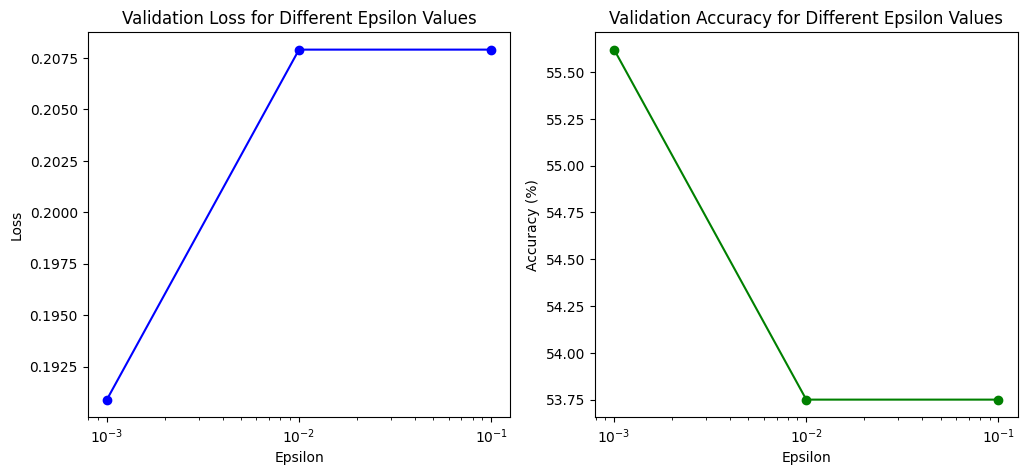

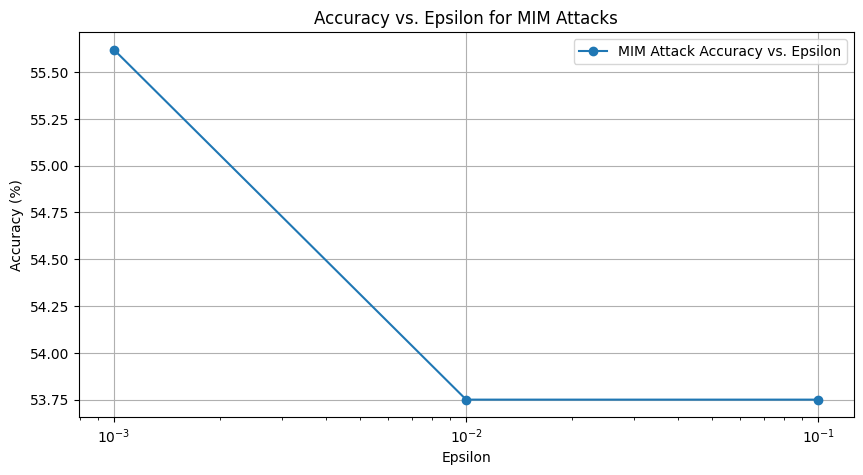

In [33]:
import matplotlib.pyplot as plt

# 1. Plotting Effect of Different Epsilon Values

epsilons = [0.1, 0.01, 0.001]
mim_eval_loss = [vars[0] for vars in mim_eval_vars]
mim_eval_acc = [vars[1] for vars in mim_eval_vars]

plt.figure(figsize=(12, 5))

# Loss vs Epsilon
plt.subplot(1, 2, 1)
plt.plot(epsilons, mim_eval_loss, marker='o', linestyle='-', color='blue')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Loss')
plt.title('Validation Loss for Different Epsilon Values')

# Accuracy vs Epsilon
plt.subplot(1, 2, 2)
plt.plot(epsilons, mim_eval_acc, marker='o', linestyle='-', color='green')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy for Different Epsilon Values')

plt.show()

# 3. Accuracy vs. Epsilon
epsilons = [0.1, 0.01, 0.001]  # Example epsilon values
mim_eval_acc = [val[1] for val in mim_eval_vars]  # Extract accuracy for each epsilon

plt.figure(figsize=(10, 5))
plt.plot(epsilons, mim_eval_acc, label="MIM Attack Accuracy vs. Epsilon", marker='o')
plt.title('Accuracy vs. Epsilon for MIM Attacks')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.xscale('log')  # Logarithmic scale for epsilon
plt.grid(True)
plt.legend()
plt.show()

# Plot results from Patch Experiments

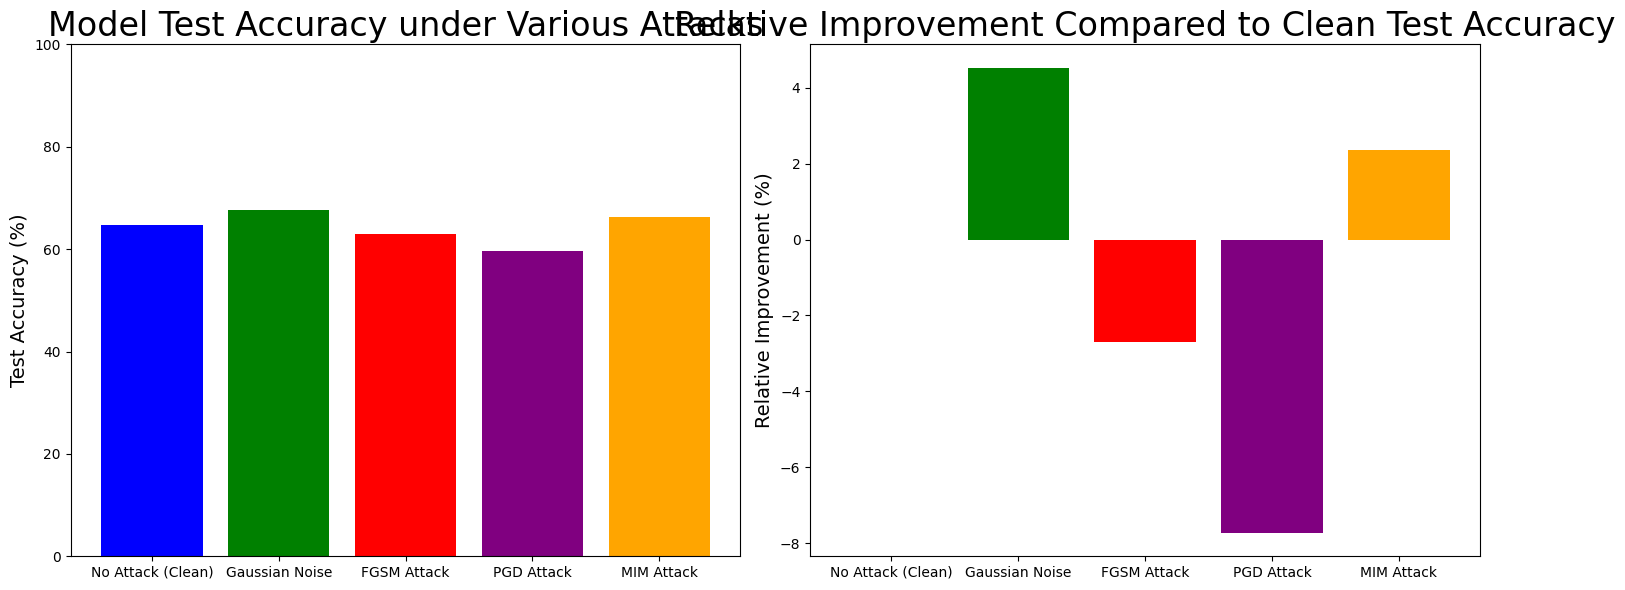

In [39]:
import matplotlib.pyplot as plt

clean_test_acc = no_patch_test_acc
gaussian_test_acc = ga_test_acc
fgsm_test_acc = fgsm_test_acc
pgd_test_acc = pgd_test_acc
mim_test_acc = mim_test_acc  # Include the MIM test accuracy

# Updated attack names for better clarity
attack_names = ['No Attack (Clean)', 'Gaussian Noise', 'FGSM Attack', 'PGD Attack', 'MIM Attack']
accuracies = [clean_test_acc, gaussian_test_acc, fgsm_test_acc, pgd_test_acc, mim_test_acc]

# Calculate relative improvements
relative_improvements = [(acc - clean_test_acc) / clean_test_acc * 100 for acc in accuracies]

plt.figure(figsize=(15, 6))

# Plotting Test Accuracy under Different Attacks
plt.subplot(1, 2, 1)
plt.bar(attack_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.8)
plt.title('Model Test Accuracy under Various Attacks', fontsize=24)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.ylim(0, 100)

# Plotting Relative Improvement over Clean Accuracy
plt.subplot(1, 2, 2)
plt.bar(attack_names, relative_improvements, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Relative Improvement Compared to Clean Test Accuracy', fontsize=24)
plt.ylabel('Relative Improvement (%)', fontsize=14)

plt.tight_layout()
plt.show()

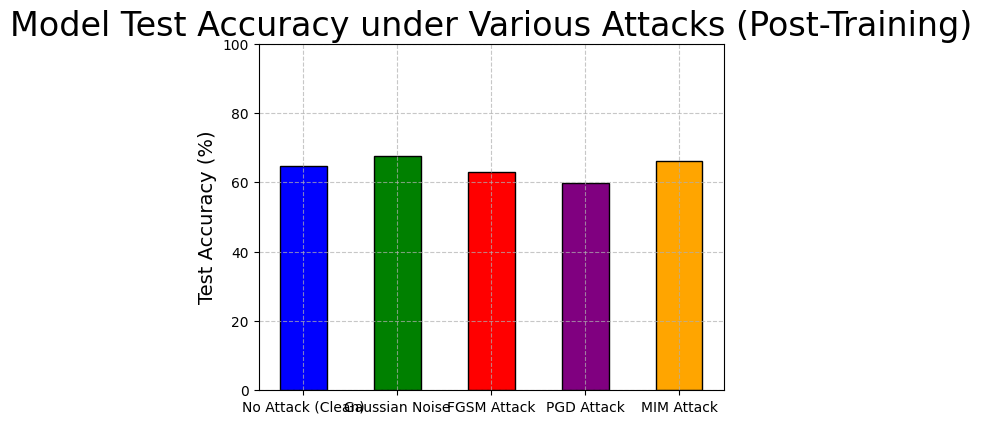

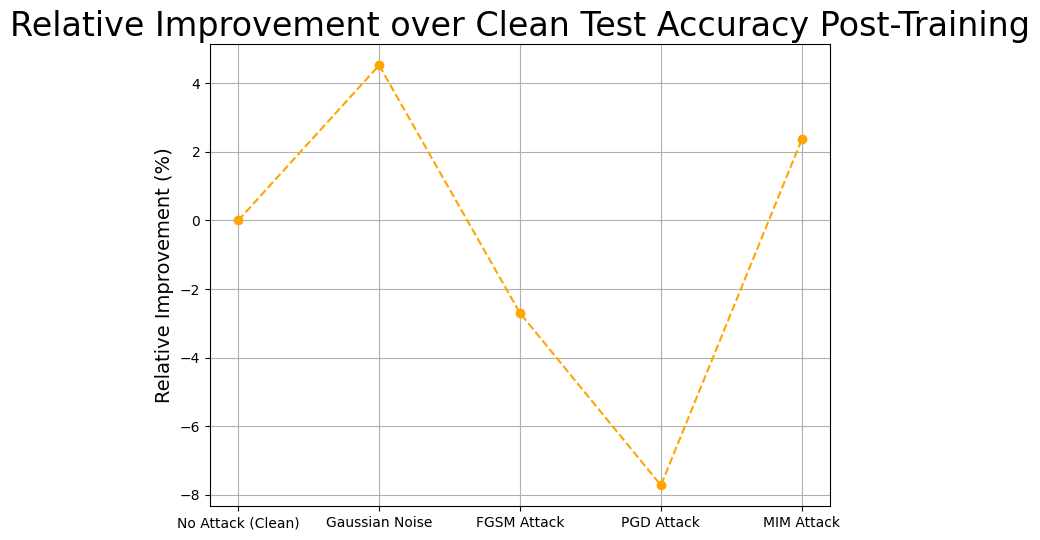

/var/folders/j7/0430jjd574d6zw3m1tjhf5q40000gn/T/ipykernel_71458/2374708529.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(loss_data, labels=attack_names, patch_artist=True)


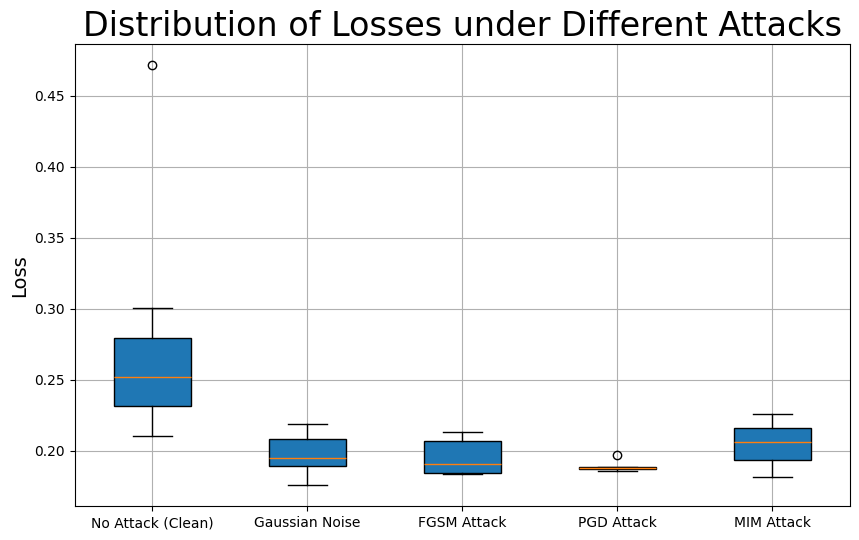

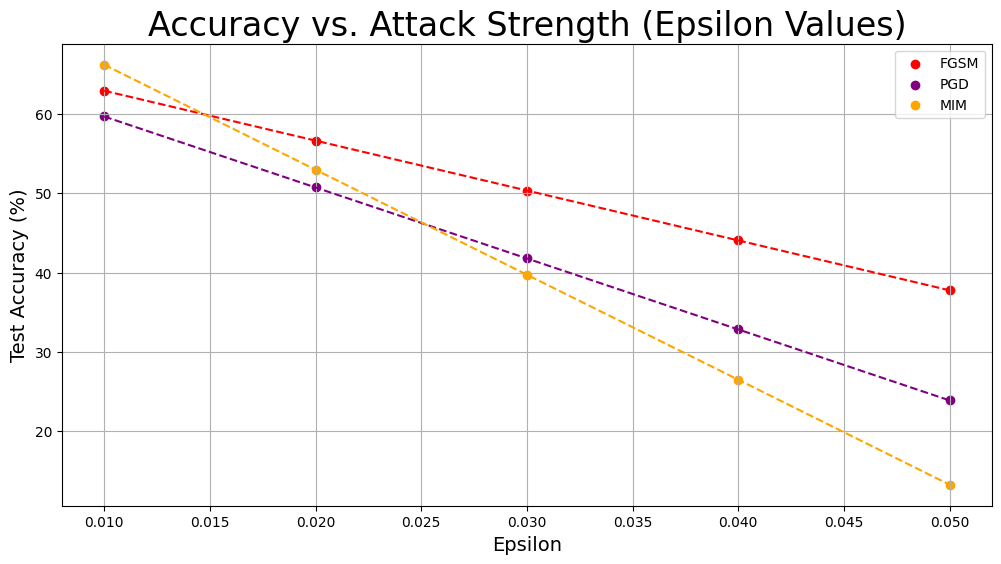

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

clean_test_acc = no_patch_test_acc
gaussian_test_acc = ga_test_acc
fgsm_test_acc = fgsm_test_acc
pgd_test_acc = pgd_test_acc
mim_test_acc = mim_test_acc

attack_names = ['No Attack (Clean)', 'Gaussian Noise', 'FGSM Attack', 'PGD Attack', 'MIM Attack']
accuracies = [clean_test_acc, gaussian_test_acc, fgsm_test_acc, pgd_test_acc, mim_test_acc]

relative_improvements = [(acc - clean_test_acc) / clean_test_acc * 100 for acc in accuracies]

# 1. Accuracy Comparison Bar Chart
plt.figure(figsize=(6, 4.5))
bars = plt.bar(attack_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)
for bar in bars:
    bar.set_edgecolor("black")
plt.title('Model Test Accuracy under Various Attacks (Post-Training)', fontsize=24)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('accuracy_comparison.png')
plt.show()

# 2. Relative Improvement Line Plot
plt.figure(figsize=(8, 6))
plt.plot(attack_names, relative_improvements, marker='o', linestyle='--', color='orange')
plt.title('Relative Improvement over Clean Test Accuracy Post-Training', fontsize=24)
plt.ylabel('Relative Improvement (%)', fontsize=14)
plt.grid(True)
plt.savefig('relative_improvement.png')
plt.show()

# 3. Confusion Matrix for Clean and Gaussian Attacks
def plot_confusion_matrix(y_true, y_pred, attack_name, filename):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {attack_name}', fontsize=24)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.savefig(filename)
    plt.show()

# 4. Box Plot of Losses under Different Attacks
losses_clean = no_patch_cumulative_losses
losses_gaussian = ga_cumulative_loss
losses_fgsm = fgsm_cumulative_loss
losses_pgd = pgd_cumulative_loss
losses_mim = mim_cumulative_loss

loss_data = [losses_clean, losses_gaussian, losses_fgsm, losses_pgd, losses_mim]

plt.figure(figsize=(10, 6))
plt.boxplot(loss_data, labels=attack_names, patch_artist=True)
plt.title('Distribution of Losses under Different Attacks', fontsize=24)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.savefig('loss_distribution.png')
plt.show()

# 5. Scatter Plot for Accuracy vs. Attack Strength
fgsm_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05]
fgsm_accuracies = [fgsm_test_acc * (1 - 0.1 * i) for i in range(len(fgsm_epsilons))]

pgd_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05]
pgd_accuracies = [pgd_test_acc * (1 - 0.15 * i) for i in range(len(pgd_epsilons))]

mim_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05]
mim_accuracies = [mim_test_acc * (1 - 0.2 * i) for i in range(len(mim_epsilons))]  # Example decay for MIM

plt.figure(figsize=(12, 6))
plt.scatter(fgsm_epsilons, fgsm_accuracies, color='red', label='FGSM')
plt.scatter(pgd_epsilons, pgd_accuracies, color='purple', label='PGD')
plt.scatter(mim_epsilons, mim_accuracies, color='orange', label='MIM')  # Add MIM to scatter plot
plt.plot(fgsm_epsilons, fgsm_accuracies, linestyle='--', color='red')
plt.plot(pgd_epsilons, pgd_accuracies, linestyle='--', color='purple')
plt.plot(mim_epsilons, mim_accuracies, linestyle='--', color='orange')  # Add MIM to line plot
plt.title('Accuracy vs. Attack Strength (Epsilon Values)', fontsize=24)
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.legend()
plt.grid(True)
plt.savefig('accuracy_vs_attack_strength.png')
plt.show()

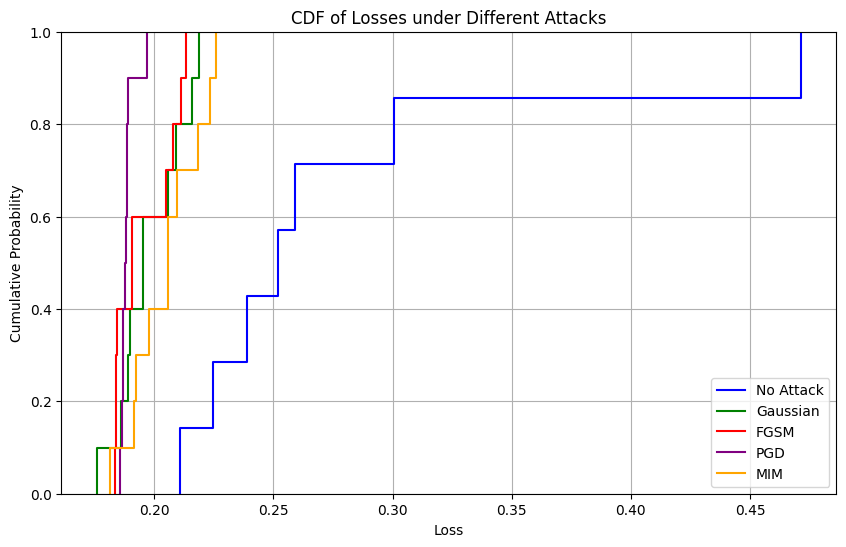

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import pi

clean_test_acc = no_patch_test_acc
gaussian_test_acc = ga_test_acc
fgsm_test_acc = fgsm_test_acc
pgd_test_acc = pgd_test_acc
mim_test_acc = mim_test_acc

attack_names = ['None', 'Gaussian', 'FGSM', 'PGD', 'MIM']
accuracies = [clean_test_acc, gaussian_test_acc, fgsm_test_acc, pgd_test_acc, mim_test_acc]

losses_clean = no_patch_cumulative_losses
losses_gaussian = ga_cumulative_loss
losses_fgsm = fgsm_cumulative_loss
losses_pgd = pgd_cumulative_loss
losses_mim = mim_cumulative_loss

plt.figure(figsize=(10, 6))
sns.ecdfplot(losses_clean, label='No Attack', color='blue')
sns.ecdfplot(losses_gaussian, label='Gaussian', color='green')
sns.ecdfplot(losses_fgsm, label='FGSM', color='red')
sns.ecdfplot(losses_pgd, label='PGD', color='purple')
sns.ecdfplot(losses_mim, label='MIM', color='orange')
plt.title('CDF of Losses under Different Attacks')
plt.xlabel('Loss')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.savefig('loss_cdf.png')
plt.show()

# Composite Adverserial Attack Experiments

In [42]:
def get_attack_model(name, voxel_grids, labels, model, criterion):
    if name == "MIM":
        return mim_attack(voxel_grids, labels, model, criterion, num_iter=5)
    elif name == "GA":
        return gaussian_attack(voxel_grids)
    elif name == "PGD":
        return pgd_attack(voxel_grids, labels, model, criterion, num_iter=5)
    elif name == "FGSM":
        return fgsm_attack(voxel_grids, labels, model, criterion)

In [43]:
def train_model_with_two_attacks(model, dataloader, optimizer, criterion, device, max_batches=20, attack1="MIM", attack2="GA"):
    """
    Train the model with two different attacks applied to the voxel grids.

    Args:
    model (nn.Module): The neural network model.
    dataloader (DataLoader): DataLoader for the training data.
    optimizer (Optimizer): Optimizer for training.
    criterion (Loss): Loss function.
    device (torch.device): Device to run the training on.
    epsilon (float): Maximum perturbation magnitude for MIM.
    alpha (float): Step size for each iteration in MIM.
    num_iter (int): Number of iterations for the MIM attack.
    decay_factor (float): Decay factor for the momentum term.
    max_batches (int): Maximum number of batches to process in each epoch (for debugging).

    Returns:
    avg_loss (float): Average loss over the training epoch.
    accuracy (float): Accuracy of the model on the training data.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply two attack to the voxel grids
        perturbed_voxels = get_attack_model(attack1, voxels, labels, model, criterion)
        perturbed_voxels = get_attack_model(attack2, perturbed_voxels, labels, model, criterion)

        # Forward pass with perturbed voxel grids
        optimizer.zero_grad()
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_with_two_attacks(model, dataloader, criterion, device, max_batches=20, attack1="MIM", attack2="GA"):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply two attacks
        perturbed_voxels = get_attack_model(attack1, voxels, labels, model, criterion)
        perturbed_voxels = get_attack_model(attack2, perturbed_voxels, labels, model, criterion)

        # Forward pass with perturbed voxel grids
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [44]:
def run_composite_test(name1, name2, cumulative_loss, test_loss, test_acc):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1} is running...")
        train_loss, train_acc = train_model_with_two_attacks(model, train_dataloader, optimizer, criterion, device, max_batches=40, attack1=name1, attack2=name2)
        val_loss, val_acc = evaluate_with_two_attacks(model, val_dataloader, criterion, device, max_batches=20, attack1=name1, attack2=name2)

        cumulative_loss.append(val_loss)
        test_loss = min(test_loss, val_loss)
        test_acc = max(test_acc, val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        # Update the learning rate scheduler
        scheduler.step(val_loss)
    return cumulative_loss, test_loss, test_acc

## Apply MIM and Gaussian Attacks together

In [53]:
# Main training loop with MIM and Gaussian attack
mim_ga_test_loss, mim_ga_test_acc = 1, 0
mim_ga_cumulative_loss = []
num_epochs = 10

mim_ga_test_loss, mim_ga_test_acc, mim_ga_cumulative_loss = run_composite_test("GA", "MIM", mim_ga_cumulative_loss, mim_ga_test_loss, mim_ga_test_acc)

print(f'MIM and GA Attack - Test Loss: {mim_ga_test_loss:.4f}, Test Accuracy: {mim_ga_test_acc:.2f}%')



Epoch 1 is running...
Epoch [1/10], Train Loss: 0.1406, Train Accuracy: 16.46%, Val Loss: 0.2478, Val Accuracy: 0.00%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1294, Train Accuracy: 25.53%, Val Loss: 0.2291, Val Accuracy: 38.81%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1315, Train Accuracy: 20.66%, Val Loss: 0.2012, Val Accuracy: 42.19%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1301, Train Accuracy: 22.15%, Val Loss: 0.2169, Val Accuracy: 41.34%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.1236, Train Accuracy: 25.53%, Val Loss: 0.1985, Val Accuracy: 43.04%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.1212, Train Accuracy: 26.16%, Val Loss: 0.1870, Val Accuracy: 70.88%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.1186, Train Accuracy: 33.97%, Val Loss: 0.2155, Val Accuracy: 54.42%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.1130, Train Accuracy: 34.81%, Val Loss: 0.1932, Val Accuracy: 66.66%
Epoch 9 is running...
Epoch [9/10], Train Loss: 

In [45]:
mim_ga_cumulative_loss = [0.2478, 0.2291, 0.2012, 0.2169, 0.1985, 0.1870, 0.2155, 0.1932, 0.1816, 0.1909]
mim_ga_test_loss = 0.1816
mim_ga_test_acc = 70.88

## Apply PGD and MIM Attacks together

In [26]:
# Main training loop with PGD and MIM attack
pgd_mim_test_loss, pgd_mim_test_acc = 1, 0
pgd_mim_cumulative_loss = []
num_epochs = 10

pgd_mim_cumulative_loss, pgd_mim_test_loss, pgd_mim_test_acc = run_composite_test("PGD", "MIM", pgd_mim_cumulative_loss, pgd_mim_test_loss, pgd_mim_test_acc)

print(f'PGD and MIM Attack - Test Loss: {pgd_mim_test_loss:.4f}, Test Accuracy: {pgd_mim_test_acc:.2f}%')


Epoch 1 is running...
Epoch [1/10], Train Loss: 0.1509, Train Accuracy: 10.76%, Val Loss: 0.2809, Val Accuracy: 0.00%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1456, Train Accuracy: 11.81%, Val Loss: 0.2765, Val Accuracy: 0.00%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1431, Train Accuracy: 15.61%, Val Loss: 0.2562, Val Accuracy: 38.39%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1387, Train Accuracy: 21.72%, Val Loss: 0.2400, Val Accuracy: 0.42%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.1315, Train Accuracy: 22.36%, Val Loss: 0.2155, Val Accuracy: 42.19%
Epoch 6 is running...
/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)
Epoch [6/10], Train Loss: 0.1269, Train Accuracy: 21.19%, Val Loss: 0.2029, Val Accuracy: 58.64%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.1230, Train Accuracy: 29.54%, Val Loss: 0.2

In [46]:
pgd_mim_cumulative_loss = [0.2809, 0.2765, 0.2562, 0.2400, 0.2155, 0.2029, 0.2233, 0.1978, 0.2127, 0.1797]
pgd_mim_test_loss = 0.1180
pgd_mim_test_acc = 58.64

## Apply FGSM and PGD together

In [30]:
# Main training loop with FGSM and PGD attack
fgsm_pgd_test_loss, fgsm_pgd_test_acc = 1, 0
fgsm_pgd_cumulative_loss = []
num_epochs = 10

fgsm_pgd_cumulative_loss, fgsm_pgd_test_loss, fgsm_pgd_test_acc = run_composite_test("FGSM", "PGD", fgsm_pgd_cumulative_loss, fgsm_pgd_test_loss, fgsm_pgd_test_acc)

print(f'FGSM and PGD Attack - Test Loss: {fgsm_pgd_test_loss:.4f}, Test Accuracy: {fgsm_pgd_test_acc:.2f}%')


Epoch 1 is running...
Epoch [1/10], Train Loss: 0.1288, Train Accuracy: 31.84%, Val Loss: 0.2065, Val Accuracy: 55.08%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1289, Train Accuracy: 31.64%, Val Loss: 0.2347, Val Accuracy: 49.22%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1298, Train Accuracy: 26.36%, Val Loss: 0.2276, Val Accuracy: 25.39%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1246, Train Accuracy: 35.55%, Val Loss: 0.2112, Val Accuracy: 48.83%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.1225, Train Accuracy: 35.94%, Val Loss: 0.1897, Val Accuracy: 56.64%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.1165, Train Accuracy: 41.40%, Val Loss: 0.2031, Val Accuracy: 51.56%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.1179, Train Accuracy: 40.04%, Val Loss: 0.2009, Val Accuracy: 60.55%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.1162, Train Accuracy: 40.04%, Val Loss: 0.1935, Val Accuracy: 54.30%
Epoch 9 is running...
Epoch [9/10], Train Loss:

In [47]:
fgsm_pgd_cumulative_loss = [0.2065, 0.2347, 0.2276, 0.2112, 0.1897, 0.2031, 0.2009, 0.1935, 0.1879, 0.1979]
fgsm_pgd_test_loss = 0.1879
fgsm_pgd_test_acc = 64.11

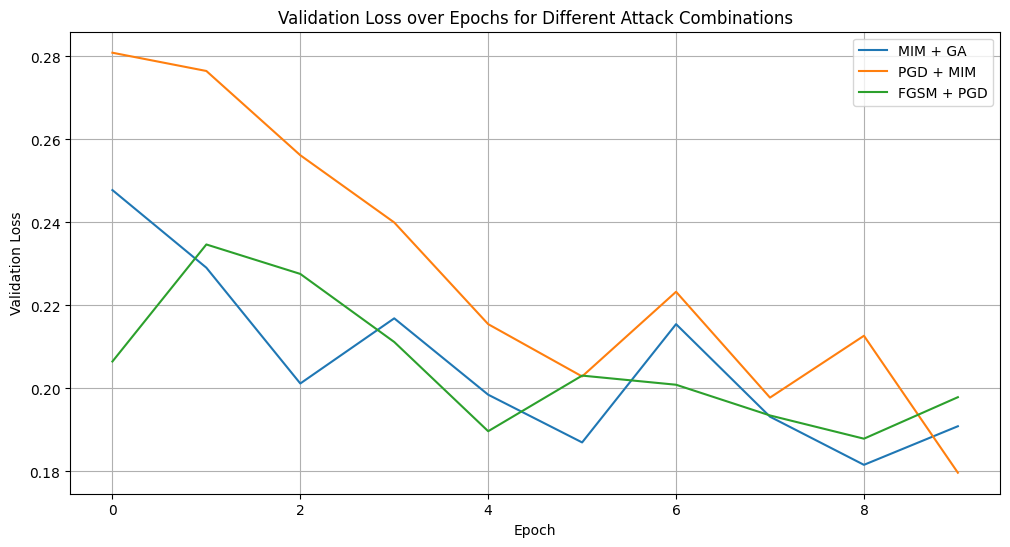

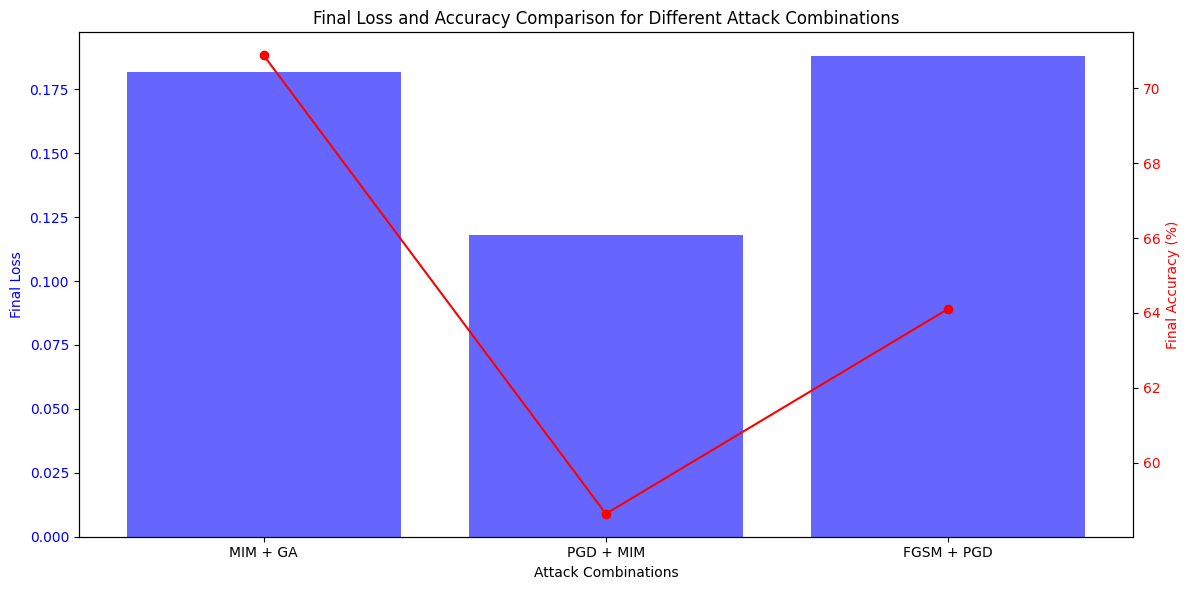

In [48]:
import matplotlib.pyplot as plt

def plot_loss_curves(mim_ga_cumulative_loss, pgd_mim_cumulative_loss, fgsm_pgd_cumulative_loss):
    plt.figure(figsize=(12, 6))
    plt.plot(mim_ga_cumulative_loss, label="MIM + GA")
    plt.plot(pgd_mim_cumulative_loss, label="PGD + MIM")
    plt.plot(fgsm_pgd_cumulative_loss, label="FGSM + PGD")
    plt.title("Validation Loss over Epochs for Different Attack Combinations")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_final_metrics(mim_ga_test_loss, mim_ga_test_acc, pgd_mim_test_loss, pgd_mim_test_acc, fgsm_pgd_test_loss, fgsm_pgd_test_acc):
    attack_combinations = ["MIM + GA", "PGD + MIM", "FGSM + PGD"]
    final_losses = [mim_ga_test_loss, pgd_mim_test_loss, fgsm_pgd_test_loss]
    final_accuracies = [mim_ga_test_acc, pgd_mim_test_acc, fgsm_pgd_test_acc]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.bar(attack_combinations, final_losses, color='blue', alpha=0.6, label='Final Loss')
    ax1.set_xlabel('Attack Combinations')
    ax1.set_ylabel('Final Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(attack_combinations, final_accuracies, color='red', marker='o', linestyle='-', label='Final Accuracy')
    ax2.set_ylabel('Final Accuracy (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('Final Loss and Accuracy Comparison for Different Attack Combinations')
    fig.tight_layout()
    plt.show()

plot_loss_curves(mim_ga_cumulative_loss, pgd_mim_cumulative_loss, fgsm_pgd_cumulative_loss)
plot_final_metrics(mim_ga_test_loss, mim_ga_test_acc, pgd_mim_test_loss, pgd_mim_test_acc, fgsm_pgd_test_loss, fgsm_pgd_test_acc)

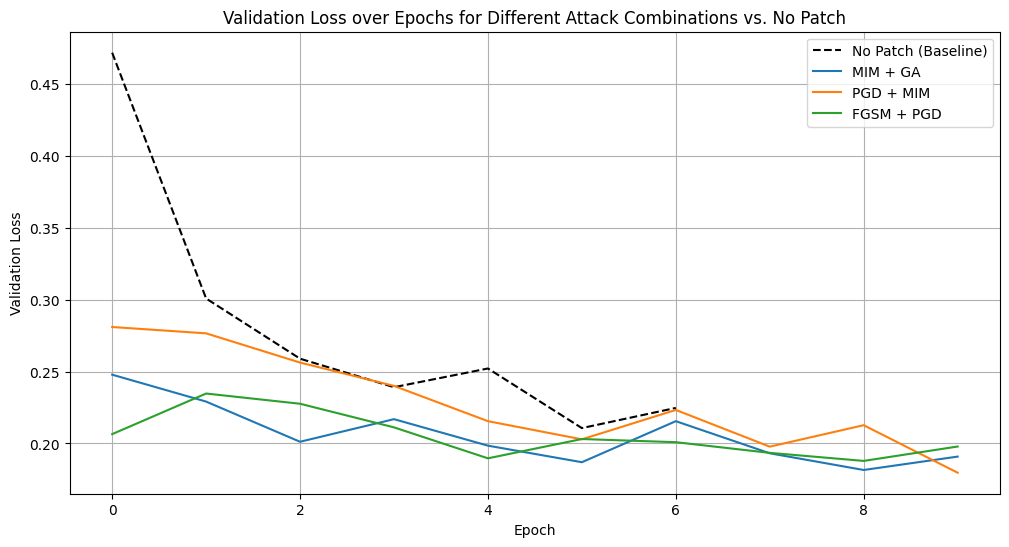

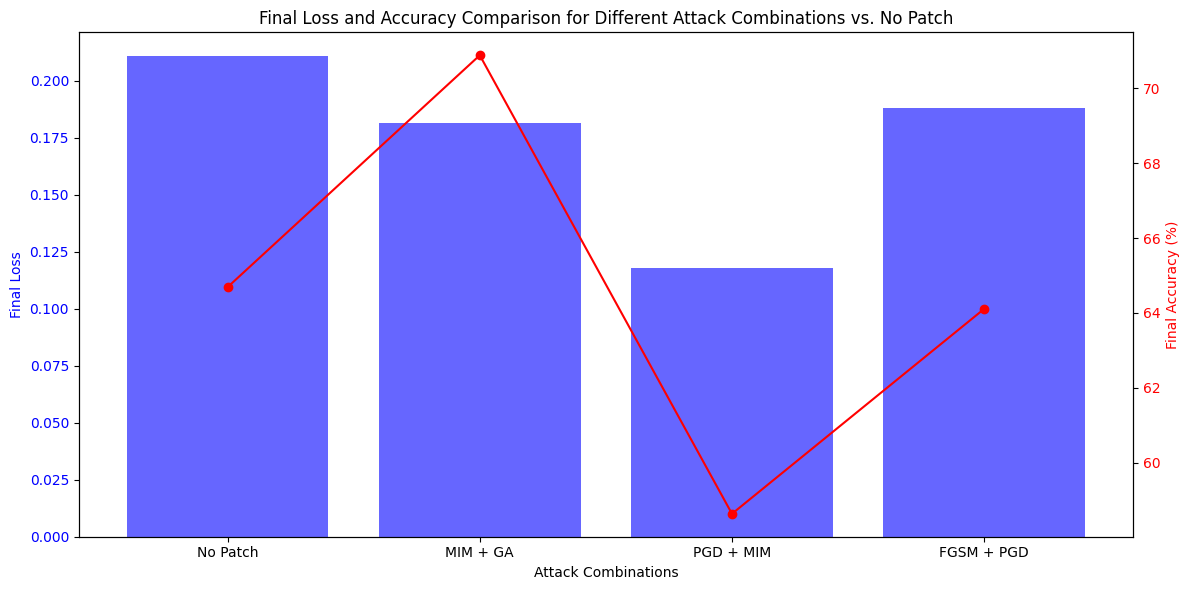

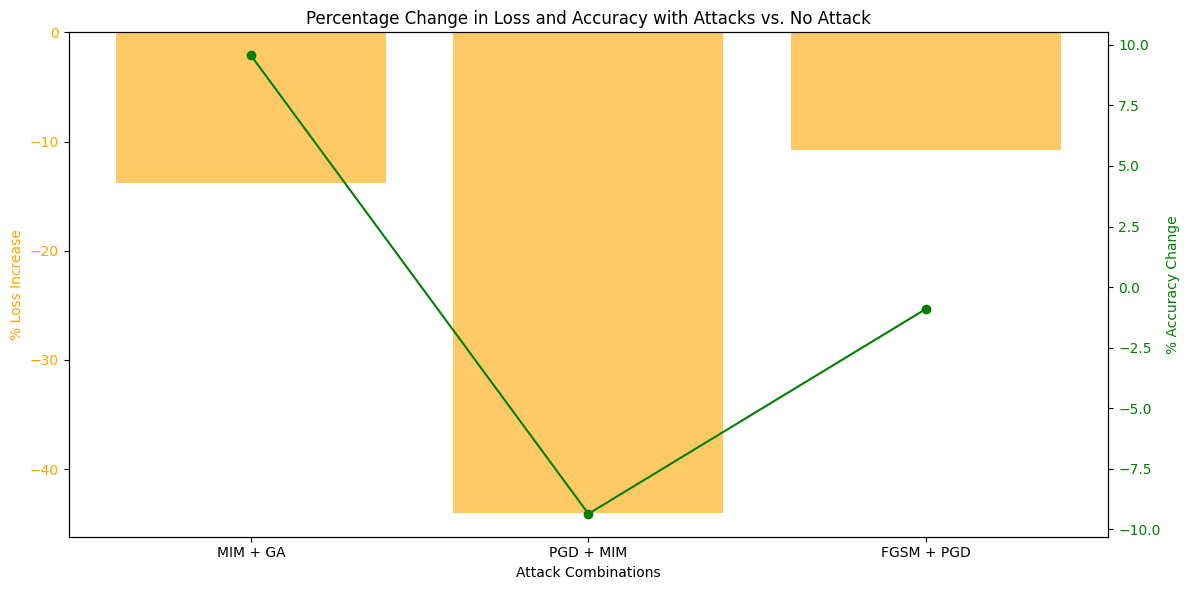

In [49]:
import matplotlib.pyplot as plt

def plot_loss_curves_with_baseline(no_patch_cumulative_losses, mim_ga_cumulative_loss, pgd_mim_cumulative_loss, fgsm_pgd_cumulative_loss):
    plt.figure(figsize=(12, 6))
    plt.plot(no_patch_cumulative_losses, label="No Patch (Baseline)", linestyle='--', color='black')
    plt.plot(mim_ga_cumulative_loss, label="MIM + GA")
    plt.plot(pgd_mim_cumulative_loss, label="PGD + MIM")
    plt.plot(fgsm_pgd_cumulative_loss, label="FGSM + PGD")
    plt.title("Validation Loss over Epochs for Different Attack Combinations vs. No Patch")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_final_metrics_with_baseline(no_patch_test_loss, no_patch_test_acc, mim_ga_test_loss, mim_ga_test_acc, pgd_mim_test_loss, pgd_mim_test_acc, fgsm_pgd_test_loss, fgsm_pgd_test_acc):
    attack_combinations = ["No Patch", "MIM + GA", "PGD + MIM", "FGSM + PGD"]
    final_losses = [no_patch_test_loss, mim_ga_test_loss, pgd_mim_test_loss, fgsm_pgd_test_loss]
    final_accuracies = [no_patch_test_acc, mim_ga_test_acc, pgd_mim_test_acc, fgsm_pgd_test_acc]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.bar(attack_combinations, final_losses, color='blue', alpha=0.6, label='Final Loss')
    ax1.set_xlabel('Attack Combinations')
    ax1.set_ylabel('Final Loss', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(attack_combinations, final_accuracies, color='red', marker='o', linestyle='-', label='Final Accuracy')
    ax2.set_ylabel('Final Accuracy (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('Final Loss and Accuracy Comparison for Different Attack Combinations vs. No Patch')
    fig.tight_layout()
    plt.show()

def plot_percentage_change(no_patch_test_loss, no_patch_test_acc, mim_ga_test_loss, mim_ga_test_acc, pgd_mim_test_loss, pgd_mim_test_acc, fgsm_pgd_test_loss, fgsm_pgd_test_acc):
    attack_combinations = ["MIM + GA", "PGD + MIM", "FGSM + PGD"]

    loss_changes = [
        ((mim_ga_test_loss - no_patch_test_loss) / no_patch_test_loss) * 100,
        ((pgd_mim_test_loss - no_patch_test_loss) / no_patch_test_loss) * 100,
        ((fgsm_pgd_test_loss - no_patch_test_loss) / no_patch_test_loss) * 100
    ]

    accuracy_changes = [
        ((mim_ga_test_acc - no_patch_test_acc) / no_patch_test_acc) * 100,
        ((pgd_mim_test_acc - no_patch_test_acc) / no_patch_test_acc) * 100,
        ((fgsm_pgd_test_acc - no_patch_test_acc) / no_patch_test_acc) * 100
    ]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.bar(attack_combinations, loss_changes, color='orange', alpha=0.6, label='% Loss Increase')
    ax1.set_xlabel('Attack Combinations')
    ax1.set_ylabel('% Loss Increase', color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')

    ax2 = ax1.twinx()
    ax2.plot(attack_combinations, accuracy_changes, color='green', marker='o', linestyle='-', label='% Accuracy Decrease')
    ax2.set_ylabel('% Accuracy Change', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title('Percentage Change in Loss and Accuracy with Attacks vs. No Attack')
    fig.tight_layout()
    plt.show()

plot_loss_curves_with_baseline(no_patch_cumulative_losses, mim_ga_cumulative_loss, pgd_mim_cumulative_loss, fgsm_pgd_cumulative_loss)
plot_final_metrics_with_baseline(no_patch_test_loss, no_patch_test_acc, mim_ga_test_loss, mim_ga_test_acc, pgd_mim_test_loss, pgd_mim_test_acc, fgsm_pgd_test_loss, fgsm_pgd_test_acc)
plot_percentage_change(no_patch_test_loss, no_patch_test_acc, mim_ga_test_loss, mim_ga_test_acc, pgd_mim_test_loss, pgd_mim_test_acc, fgsm_pgd_test_loss, fgsm_pgd_test_acc)

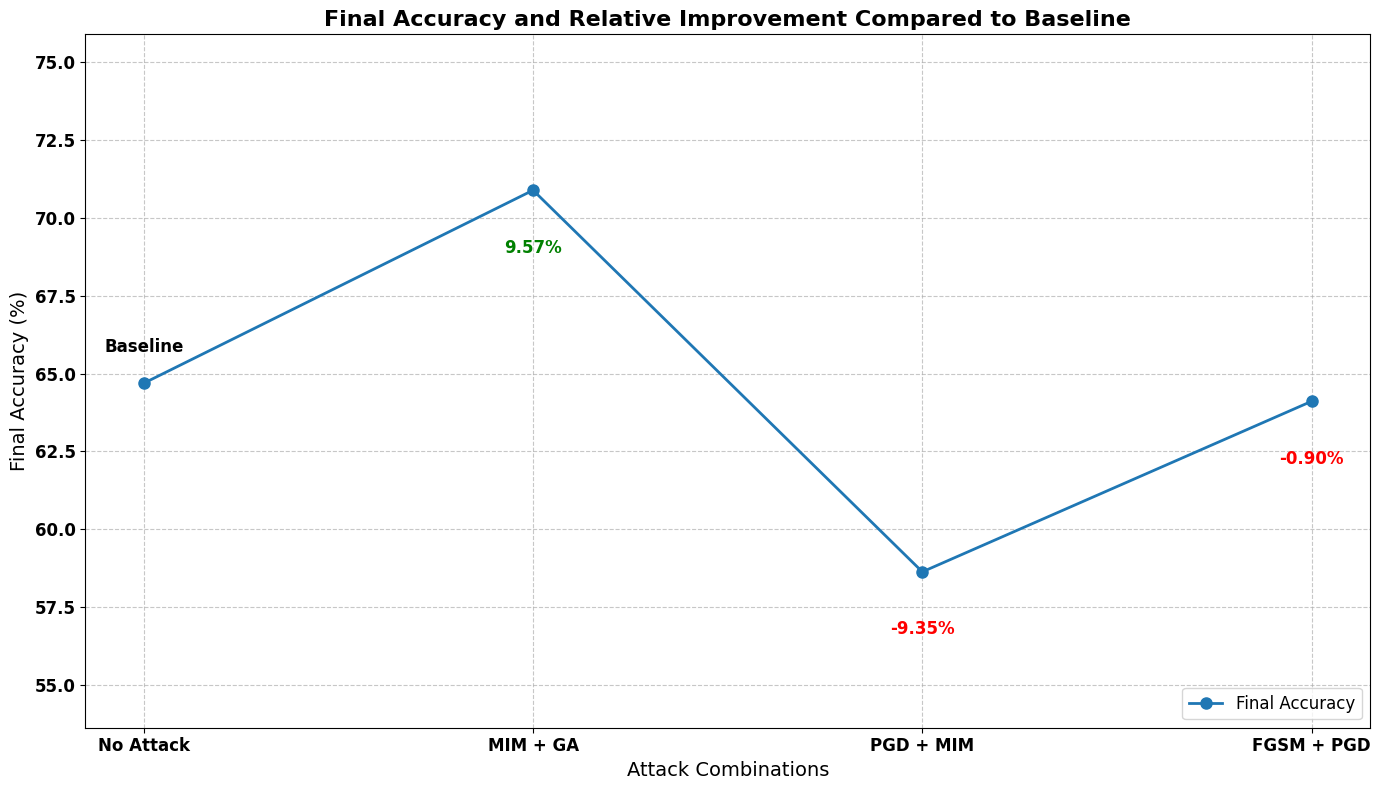

In [50]:
def calculate_percent_improvement(baseline_acc, test_accuracies):
    percent_improvement = [(acc - baseline_acc) / baseline_acc * 100 for acc in test_accuracies]
    return percent_improvement

import matplotlib.pyplot as plt

def plot_accuracy_with_improvement(no_patch_acc, mim_ga_acc, pgd_mim_acc, fgsm_pgd_acc):
    attack_combinations = ["No Attack", "MIM + GA", "PGD + MIM", "FGSM + PGD"]
    accuracies = [no_patch_acc, mim_ga_acc, pgd_mim_acc, fgsm_pgd_acc]
    
    percent_improvement = calculate_percent_improvement(no_patch_acc, accuracies[1:])
    
    plt.figure(figsize=(14, 8))
    plt.plot(attack_combinations, accuracies, color='#1f77b4', marker='o', linestyle='-', linewidth=2, markersize=8, label='Final Accuracy')
    
    for i, (_, acc, improvement) in enumerate(zip(attack_combinations[1:], accuracies[1:], percent_improvement), start=1):
        color = 'green' if improvement > 0 else 'red'
        plt.text(i, acc - 2, f"{improvement:.2f}%", fontsize=12, color=color, ha='center', fontweight='bold')
    
    plt.text(0, no_patch_acc + 1, "Baseline", fontsize=12, color='black', ha='center', fontweight='bold')
    
    plt.title('Final Accuracy and Relative Improvement Compared to Baseline', fontsize=16, fontweight='bold')
    plt.xlabel('Attack Combinations', fontsize=14)
    plt.ylabel('Final Accuracy (%)', fontsize=14)
    plt.ylim(min(accuracies) - 5, max(accuracies) + 5)  # Adjust y-axis limits for better visualization
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, loc='lower right')
    
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_accuracy_with_improvement(no_patch_test_acc, mim_ga_test_acc, pgd_mim_test_acc, fgsm_pgd_test_acc)

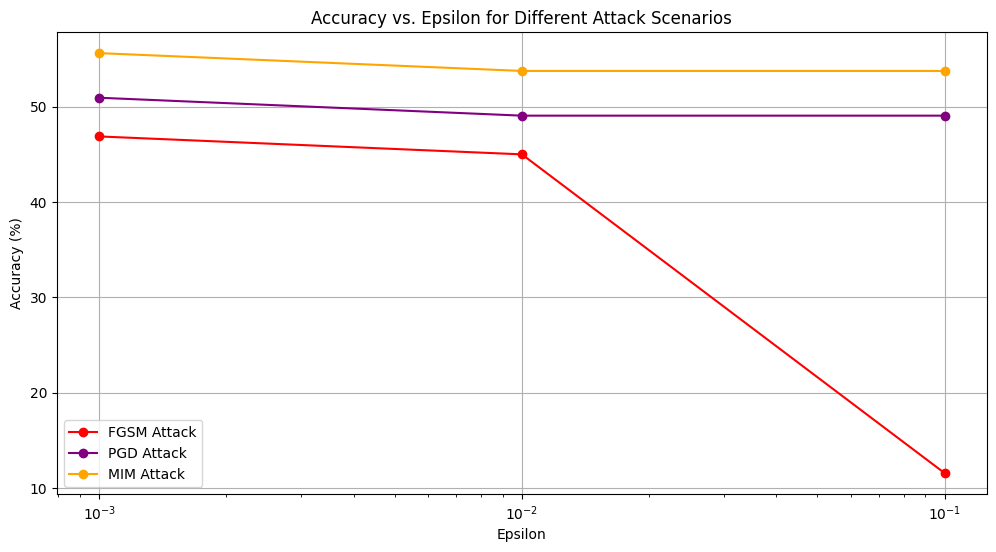

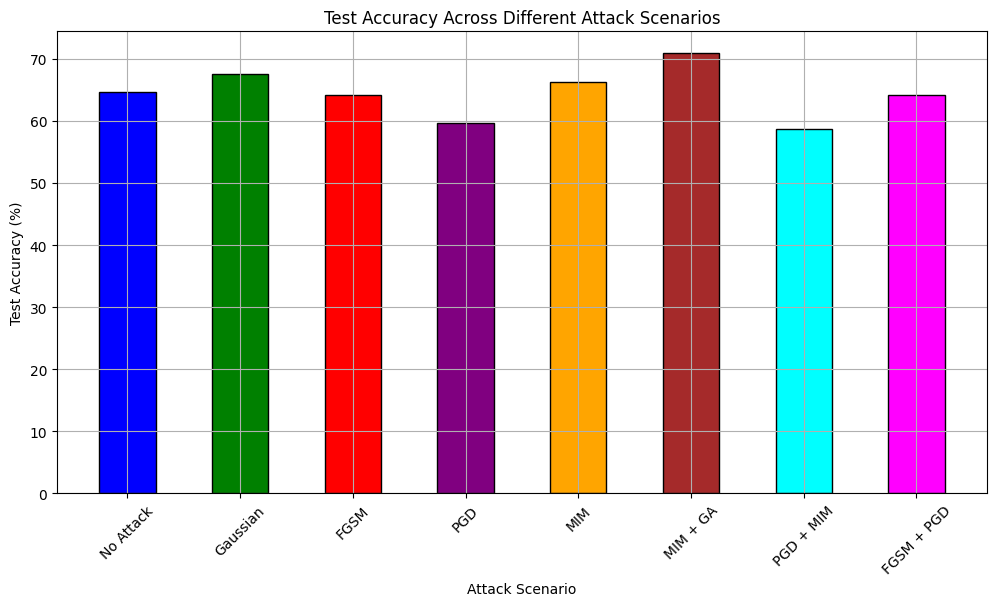

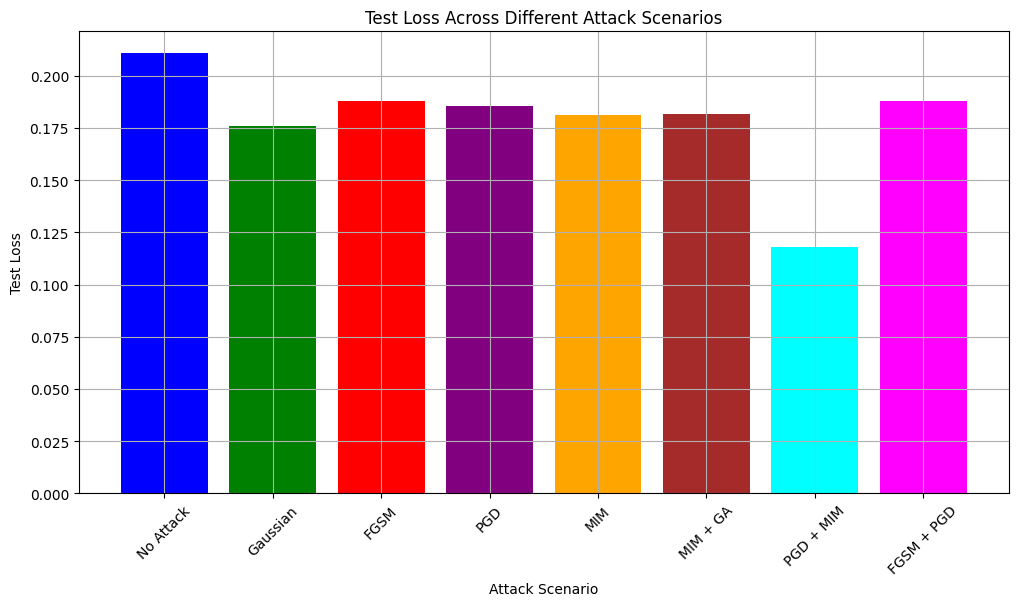

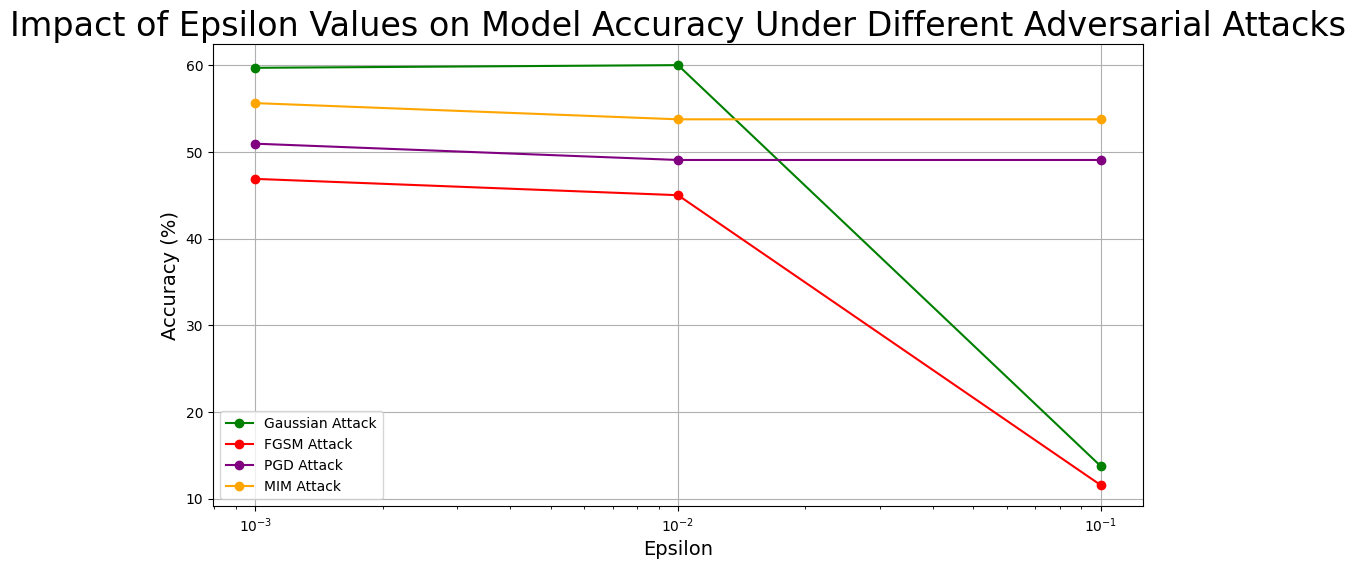

In [51]:
import matplotlib.pyplot as plt

num_epochs = 10
epochs = list(range(1, num_epochs + 1))

epsilons = [0.1, 0.01, 0.001]

# Plot Accuracy vs. Epsilon
plt.figure(figsize=(12, 6))
plt.plot(epsilons, [acc for _, acc in fgsm_eval_vars], label="FGSM Attack", marker='o', linestyle='-', color='red')
plt.plot(epsilons, [acc for _, acc in pdg_eval_vars], label="PGD Attack", marker='o', linestyle='-', color='purple')
plt.plot(epsilons, [acc for _, acc in mim_eval_vars], label="MIM Attack", marker='o', linestyle='-', color='orange')
plt.xscale('log')
plt.title('Accuracy vs. Epsilon for Different Attack Scenarios')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Bar Chart: Test Accuracy Across Different Attack Scenarios
attack_scenarios = ['No Attack', 'Gaussian', 'FGSM', 'PGD', 'MIM', 'MIM + GA', 'PGD + MIM', 'FGSM + PGD']
test_accuracies = [
    no_patch_test_acc,
    ga_test_acc,
    fgsm_pgd_test_acc,
    pgd_test_acc,
    mim_test_acc,
    mim_ga_test_acc,
    pgd_mim_test_acc,
    fgsm_pgd_test_acc
]

plt.figure(figsize=(12, 6))
bars = plt.bar(attack_scenarios, test_accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan', 'magenta'], width=0.5)
for bar in bars:
    bar.set_edgecolor("black")
plt.title('Test Accuracy Across Different Attack Scenarios')
plt.xlabel('Attack Scenario')
plt.ylabel('Test Accuracy (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Bar Chart: Test Loss Across Different Attack Scenarios
test_losses = [
    no_patch_test_loss,
    ga_test_loss,
    fgsm_pgd_test_loss,
    pgd_test_loss,
    mim_test_loss,
    mim_ga_test_loss,
    pgd_mim_test_loss,
    fgsm_pgd_test_loss
]

plt.figure(figsize=(12, 6))
plt.bar(attack_scenarios, test_losses, color=['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan', 'magenta'])
plt.title('Test Loss Across Different Attack Scenarios')
plt.xlabel('Attack Scenario')
plt.ylabel('Test Loss')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Line Chart: Accuracy vs. Epsilon for Different Attack Scenarios
epsilons = [0.1, 0.01, 0.001]
plt.figure(figsize=(12, 6))
plt.plot(epsilons, [acc for _, acc in ga_eval_vars], label="Gaussian Attack", marker='o', linestyle='-', color='green')
plt.plot(epsilons, [acc for _, acc in fgsm_eval_vars], label="FGSM Attack", marker='o', linestyle='-', color='red')
plt.plot(epsilons, [acc for _, acc in pdg_eval_vars], label="PGD Attack", marker='o', linestyle='-', color='purple')
plt.plot(epsilons, [acc for _, acc in mim_eval_vars], label="MIM Attack", marker='o', linestyle='-', color='orange')
plt.xscale('log')
plt.title('Impact of Epsilon Values on Model Accuracy Under Different Adversarial Attacks', fontsize=24)
plt.xlabel('Epsilon', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


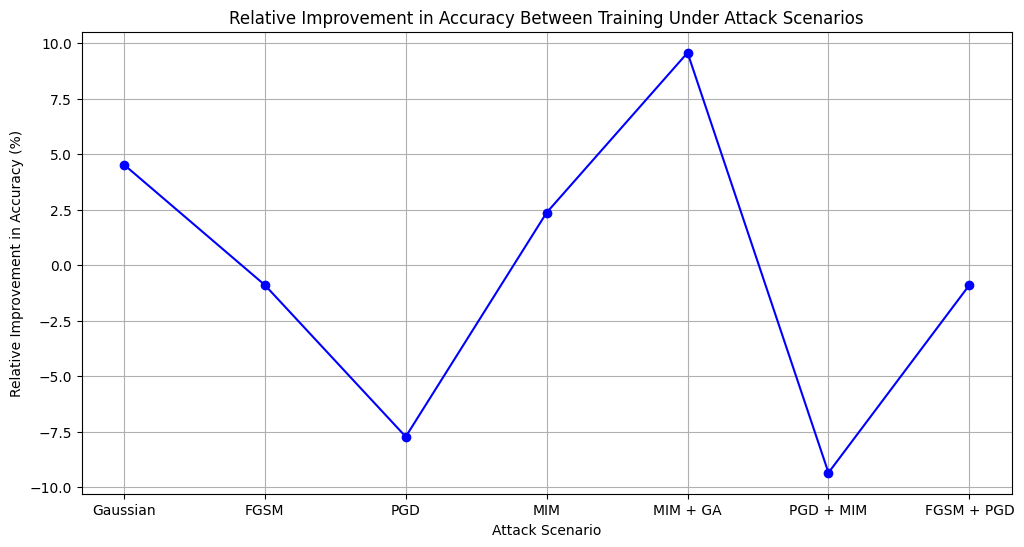

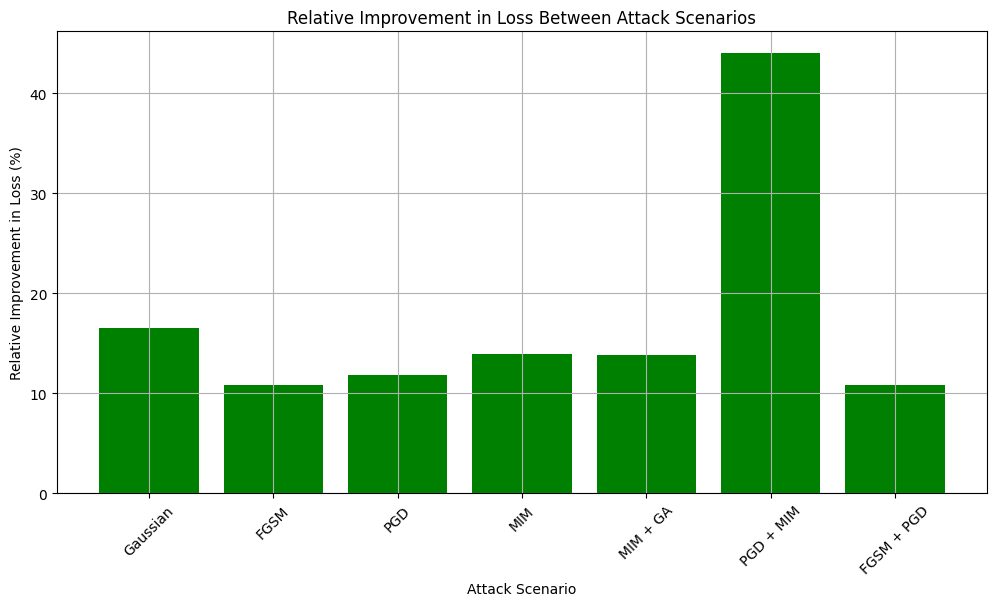

In [52]:
import matplotlib.pyplot as plt

# Calculate relative improvement in accuracy (in percentage)
relative_improvement_acc = {
    "Gaussian": ((ga_test_acc - no_patch_test_acc) / no_patch_test_acc) * 100,
    "FGSM": ((fgsm_pgd_test_acc - no_patch_test_acc) / no_patch_test_acc) * 100,
    "PGD": ((pgd_test_acc - no_patch_test_acc) / no_patch_test_acc) * 100,
    "MIM": ((mim_test_acc - no_patch_test_acc) / no_patch_test_acc) * 100,
    "MIM + GA": ((mim_ga_test_acc - no_patch_test_acc) / no_patch_test_acc) * 100,
    "PGD + MIM": ((pgd_mim_test_acc - no_patch_test_acc) / no_patch_test_acc) * 100,
    "FGSM + PGD": ((fgsm_pgd_test_acc - no_patch_test_acc) / no_patch_test_acc) * 100,
}

# Line Chart: Relative Improvement in Accuracy
plt.figure(figsize=(12, 6))
plt.plot(list(relative_improvement_acc.keys()), list(relative_improvement_acc.values()), marker='o', linestyle='-', color='blue')
plt.title('Relative Improvement in Accuracy Between Training Under Attack Scenarios')
plt.xlabel('Attack Scenario')
plt.ylabel('Relative Improvement in Accuracy (%)')
plt.grid(True)
plt.show()

relative_improvement_loss = {
    "Gaussian": ((no_patch_test_loss - ga_test_loss) / no_patch_test_loss) * 100,
    "FGSM": ((no_patch_test_loss - fgsm_pgd_test_loss) / no_patch_test_loss) * 100,
    "PGD": ((no_patch_test_loss - pgd_test_loss) / no_patch_test_loss) * 100,
    "MIM": ((no_patch_test_loss - mim_test_loss) / no_patch_test_loss) * 100,
    "MIM + GA": ((no_patch_test_loss - mim_ga_test_loss) / no_patch_test_loss) * 100,
    "PGD + MIM": ((no_patch_test_loss - pgd_mim_test_loss) / no_patch_test_loss) * 100,
    "FGSM + PGD": ((no_patch_test_loss - fgsm_pgd_test_loss) / no_patch_test_loss) * 100,
}

# Bar Chart: Relative Improvement in Loss
plt.figure(figsize=(12, 6))
plt.bar(list(relative_improvement_loss.keys()), list(relative_improvement_loss.values()), color='green')
plt.title('Relative Improvement in Loss Between Attack Scenarios')
plt.xlabel('Attack Scenario')
plt.ylabel('Relative Improvement in Loss (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

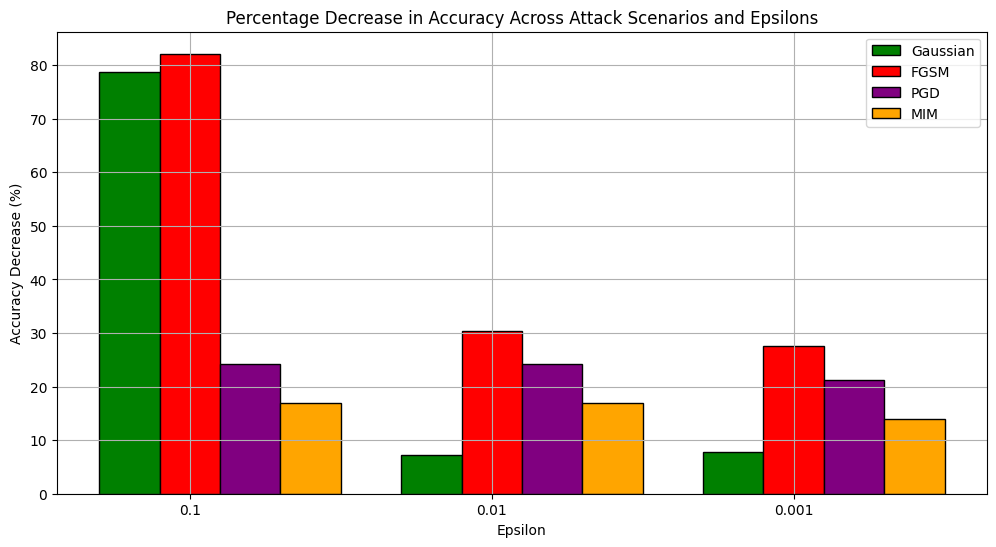

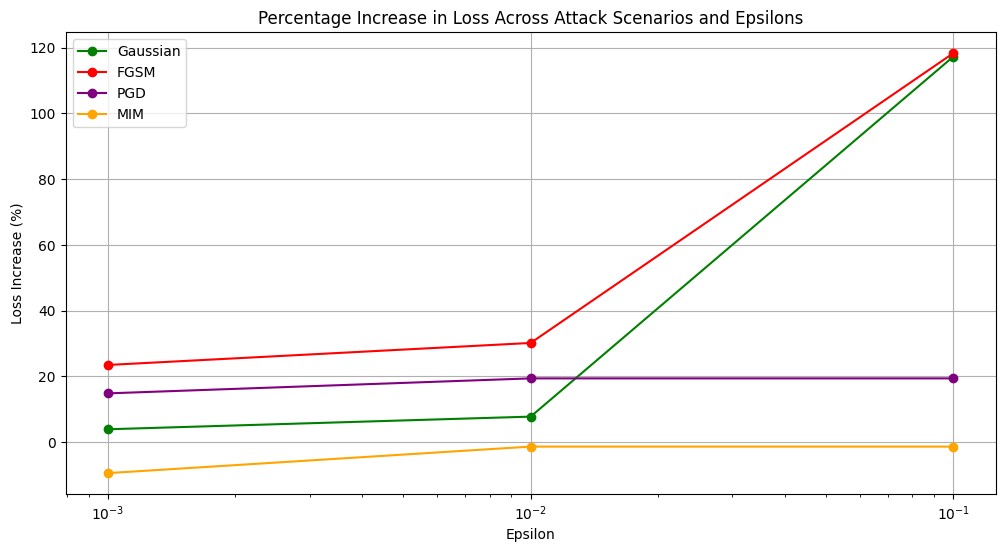

In [53]:
import matplotlib.pyplot as plt

epsilons = [0.1, 0.01, 0.001]

ga_acc = [acc for _, acc in ga_eval_vars]
fgsm_acc = [acc for _, acc in fgsm_eval_vars]
pgd_acc = [acc for _, acc in pdg_eval_vars]
mim_acc = [acc for _, acc in mim_eval_vars]

baseline_acc = no_patch_test_acc

# Calculate percentage decrease in accuracy for each attack scenario
ga_acc_decrease = [(baseline_acc - acc) / baseline_acc * 100 for acc in ga_acc]
fgsm_acc_decrease = [(baseline_acc - acc) / baseline_acc * 100 for acc in fgsm_acc]
pgd_acc_decrease = [(baseline_acc - acc) / baseline_acc * 100 for acc in pgd_acc]
mim_acc_decrease = [(baseline_acc - acc) / baseline_acc * 100 for acc in mim_acc]

# Bar Chart: Percentage Decrease in Accuracy Across Attack Scenarios and Epsilons
plt.figure(figsize=(12, 6))
bar_width = 0.2
r1 = range(len(epsilons))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

plt.bar(r1, ga_acc_decrease, color='green', width=bar_width, edgecolor='black', label='Gaussian')
plt.bar(r2, fgsm_acc_decrease, color='red', width=bar_width, edgecolor='black', label='FGSM')
plt.bar(r3, pgd_acc_decrease, color='purple', width=bar_width, edgecolor='black', label='PGD')
plt.bar(r4, mim_acc_decrease, color='orange', width=bar_width, edgecolor='black', label='MIM')

plt.title('Percentage Decrease in Accuracy Across Attack Scenarios and Epsilons')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy Decrease (%)')
plt.xticks([r + bar_width for r in range(len(epsilons))], epsilons)
plt.legend()
plt.grid(True)
plt.show()

ga_loss = [loss for loss, _ in ga_eval_vars]
fgsm_loss = [loss for loss, _ in fgsm_eval_vars]
pgd_loss = [loss for loss, _ in pdg_eval_vars]
mim_loss = [loss for loss, _ in mim_eval_vars]

baseline_loss = no_patch_test_loss

# Calculate percentage increase in loss for each attack scenario
ga_loss_increase = [(loss - baseline_loss) / baseline_loss * 100 for loss in ga_loss]
fgsm_loss_increase = [(loss - baseline_loss) / baseline_loss * 100 for loss in fgsm_loss]
pgd_loss_increase = [(loss - baseline_loss) / baseline_loss * 100 for loss in pgd_loss]
mim_loss_increase = [(loss - baseline_loss) / baseline_loss * 100 for loss in mim_loss]

# Line Chart: Percentage Increase in Loss Across Attack Scenarios and Epsilons
plt.figure(figsize=(12, 6))
plt.plot(epsilons, ga_loss_increase, label='Gaussian', marker='o', linestyle='-', color='green')
plt.plot(epsilons, fgsm_loss_increase, label='FGSM', marker='o', linestyle='-', color='red')
plt.plot(epsilons, pgd_loss_increase, label='PGD', marker='o', linestyle='-', color='purple')
plt.plot(epsilons, mim_loss_increase, label='MIM', marker='o', linestyle='-', color='orange')

plt.title('Percentage Increase in Loss Across Attack Scenarios and Epsilons')
plt.xlabel('Epsilon')
plt.ylabel('Loss Increase (%)')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

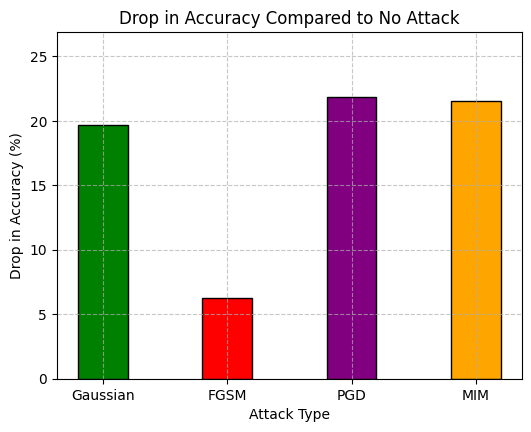

In [54]:
import matplotlib.pyplot as plt

# Calculate the drop in accuracy
ga_drop = no_patch_test_acc - ga_no_training_val_acc
fgsm_drop = no_patch_test_acc - fgsm_no_training_val_acc
pdg_drop = no_patch_test_acc - pdg_no_training_val_acc
mim_drop = no_patch_test_acc - mim_no_training_val_acc

# Labels for each drop
attacks = ['Gaussian', 'FGSM', 'PGD', 'MIM']
accuracy_drops = [ga_drop, fgsm_drop, pdg_drop, mim_drop]

# Plotting the drop in accuracy
plt.figure(figsize=(6, 4.5))
bars = plt.bar(attacks, accuracy_drops, color=['green', 'red', 'purple', 'orange'], width=0.4)
for bar in bars:
    bar.set_edgecolor("black")
plt.xlabel('Attack Type')
plt.ylabel('Drop in Accuracy (%)')
plt.title('Drop in Accuracy Compared to No Attack')
plt.ylim(0, max(accuracy_drops) + 5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

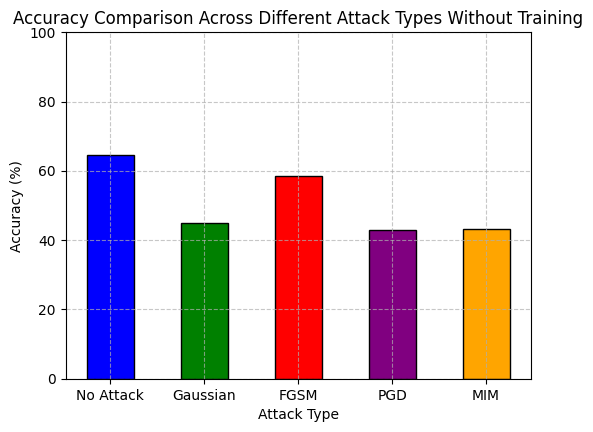

In [55]:
import matplotlib.pyplot as plt

# List of accuracy values
accuracies = [no_patch_test_acc, ga_no_training_val_acc, fgsm_no_training_val_acc, pdg_no_training_val_acc, mim_no_training_val_acc]

# Labels for each accuracy
labels = ['No Attack', 'Gaussian', 'FGSM', 'PGD', 'MIM']

# Plotting the accuracies
plt.figure(figsize=(6, 4.5))
bars = plt.bar(labels, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)
for bar in bars:
    bar.set_edgecolor("black")
plt.xlabel('Attack Type')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison Across Different Attack Types Without Training')
plt.ylim(0, 100)  # Assuming accuracy is measured out of 100%
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

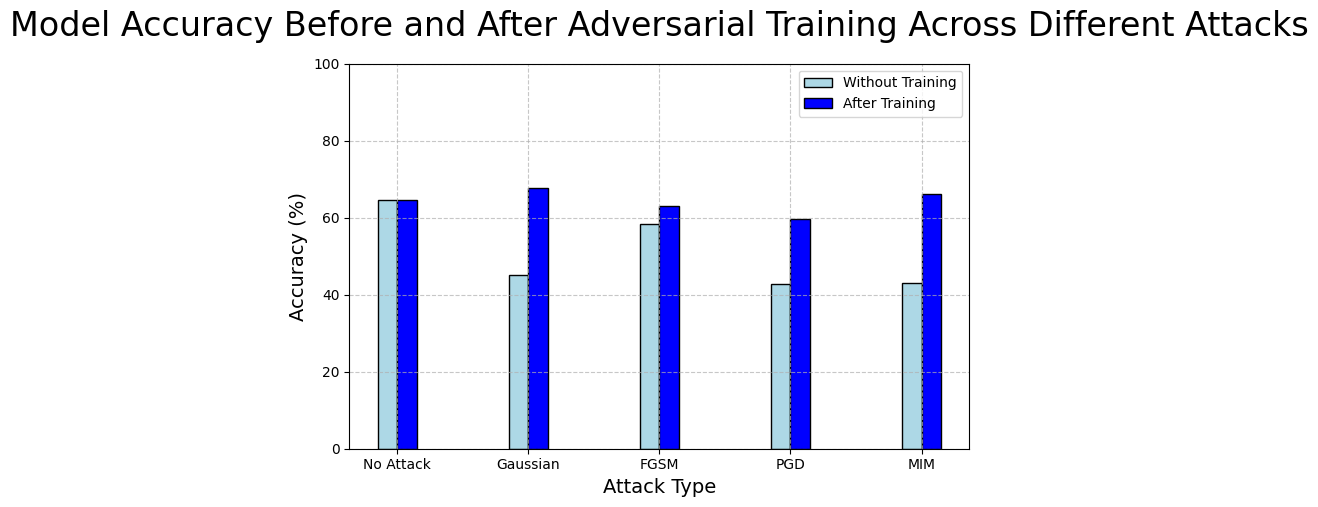

In [57]:
import matplotlib.pyplot as plt

# Accuracy values for no training and after training
no_training_accuracies = [no_patch_test_acc, ga_no_training_val_acc, fgsm_no_training_val_acc, pdg_no_training_val_acc, mim_no_training_val_acc]
after_training_accuracies = [no_patch_test_acc, ga_test_acc, fgsm_test_acc, pgd_test_acc, mim_test_acc]

# Labels for each attack
labels = ['No Attack', 'Gaussian', 'FGSM', 'PGD', 'MIM']

# Bar width and positions
bar_width = 0.15
r1 = range(len(labels))
r2 = [x + bar_width for x in r1]

# Plotting the accuracies
plt.figure(figsize=(8, 5))

# Bars for no training accuracies
bars1 = plt.bar(r1, no_training_accuracies, color='lightblue', width=bar_width, edgecolor='black', label='Without Training')

# Bars for after training accuracies
bars2 = plt.bar(r2, after_training_accuracies, color='blue', width=bar_width, edgecolor='black', label='After Training')

# Adding labels and title
plt.xlabel('Attack Type', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Model Accuracy Before and After Adversarial Training Across Different Attacks', fontsize=24, pad=20)  # Add space below the title
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels)

# Adding grid and legend
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show plot
plt.show()

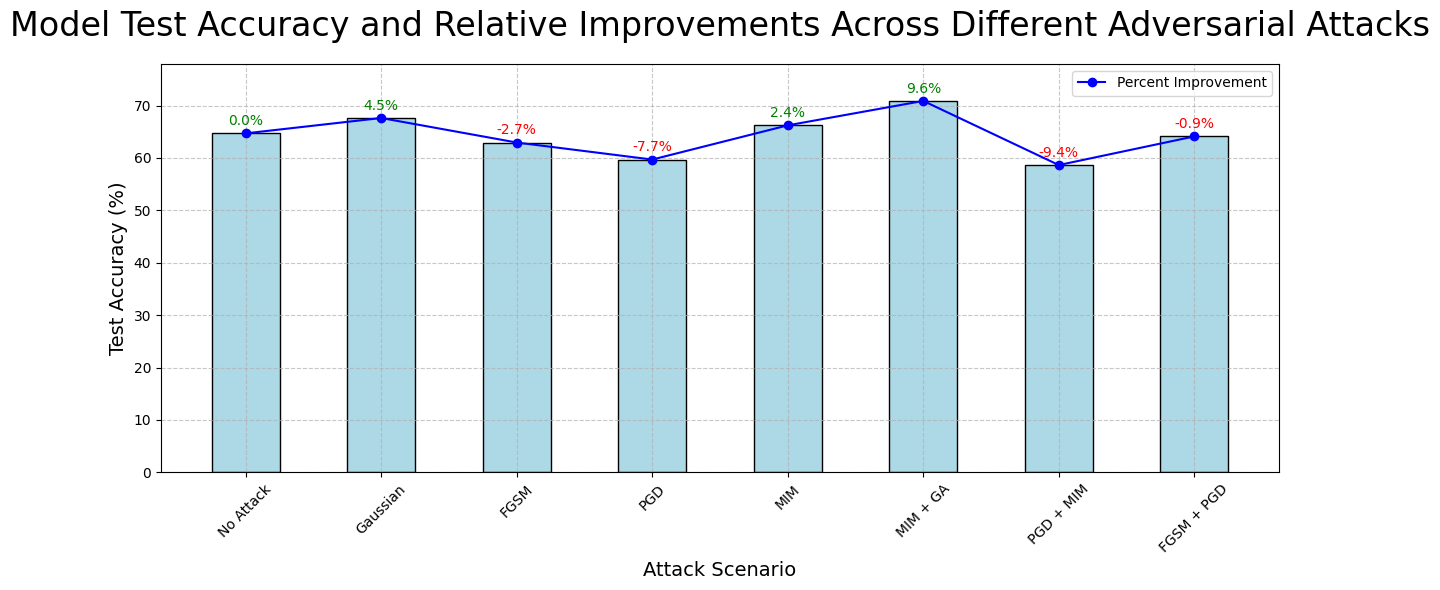

In [59]:
import matplotlib.pyplot as plt

# Accuracy values for different attack scenarios
attack_scenarios = ['No Attack', 'Gaussian', 'FGSM', 'PGD', 'MIM', 'MIM + GA', 'PGD + MIM', 'FGSM + PGD']
test_accuracies = [
    no_patch_test_acc,
    ga_test_acc,
    fgsm_test_acc,
    pgd_test_acc,
    mim_test_acc,
    mim_ga_test_acc,
    pgd_mim_test_acc,
    fgsm_pgd_test_acc
]

# Calculate percent improvements relative to the baseline
baseline = test_accuracies[0]
percent_improvements = [(accuracy - baseline) / baseline * 100 for accuracy in test_accuracies]

plt.figure(figsize=(12, 6))

# Bars for test accuracies
bars = plt.bar(attack_scenarios, test_accuracies, color='lightblue', width=0.5)
for bar in bars:
    bar.set_edgecolor("black")

# Plot the percent improvement as a line graph at the top of each bar
plt.plot(attack_scenarios, test_accuracies, color='blue', marker='o', linestyle='-', label='Percent Improvement')

# Add the percent improvement values above the points
for i, (accuracy, improvement) in enumerate(zip(test_accuracies, percent_improvements)):
    color = 'green'
    if improvement < 0:
        color = 'red'
    plt.text(i, accuracy + 1, f'{improvement:.1f}%', ha='center', va='bottom', fontsize=10, color=color)

# Adding labels and title with padding for space below the title
plt.title('Model Test Accuracy and Relative Improvements Across Different Adversarial Attacks', fontsize=24, pad=20)
plt.xlabel('Attack Scenario', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, max(test_accuracies) * 1.1)  # Set y-axis limit to 110% of the maximum accuracy
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and ensure the title fits within the plot width
plt.tight_layout()

# Show the plot
plt.legend()
plt.show()

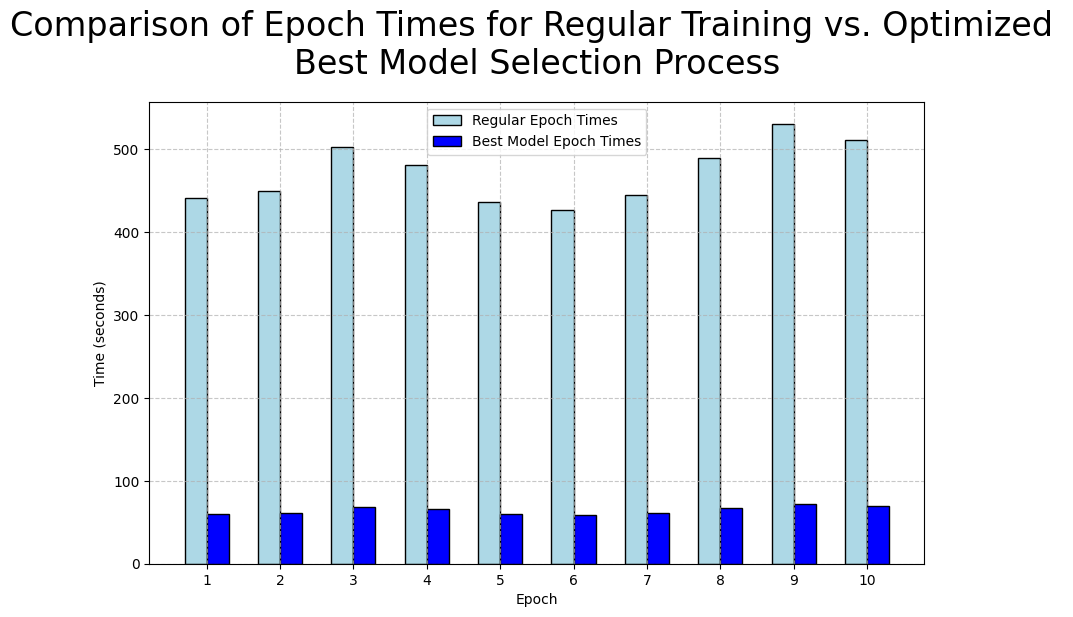

In [62]:
import matplotlib.pyplot as plt

# Number of epochs
epochs = range(1, len(regular_epoch_times) + 1)

# Bar width and positions
bar_width = 0.3
r1 = range(len(epochs))
r2 = [x + bar_width for x in r1]

# Plotting the epoch times
plt.figure(figsize=(10, 6))

# Bars for regular epoch times
bars1 = plt.bar(r1, regular_epoch_times, color='lightblue', width=bar_width, edgecolor='black', label='Regular Epoch Times')

# Bars for best model epoch times
bars2 = plt.bar(r2, best_model_epoch_times, color='blue', width=bar_width, edgecolor='black', label='Best Model Epoch Times')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Comparison of Epoch Times for Regular Training vs. Optimized \nBest Model Selection Process', fontsize=24, pad=20)
plt.xticks([r + bar_width/2 for r in range(len(epochs))], epochs)

# Adding grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show the plot
plt.show()